# FRAUD DETECTION PROJECT

Blocker Fraud Company is a company specialized in fraud detection of financial transactions made through mobile devices. Their clients pay for the service based on the number of transactions correctly analyzed. The objective is to measure the efficiency of their fraud detection model and answer the questions:

- What are the model's precision and accuracy?
- How reliable is the model in classifying transactions as legitimate or fraudulent?


## INDEX

- **0.0.** Data Collection
- **1.0.** Data description
- **2.0.** Feature engineering
- **3.0.** Data Filtering
- **4.0.** Exploratory data analysis
- **5.0.** Data preparation
- **6.0.** Feature selection
- **7.0.** Imbalanced dataset
- **8.0.** Machine learning modelling
- **9.0.** Hyperparameter fine tuning
- **10.0.** Business Performance
- **11.0.** Deploy model to production


# 0.0. DATA COLLECTION
## 0.1 Imports

In [1]:
#data manipulation
import pandas as pd
import numpy as np

#data viz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#balanced data
from imblearn                import under_sampling as us
from imblearn                import over_sampling as os
from imblearn                import combine as c

#data preparation
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict,RandomizedSearchCV

#machine learning algorithms
from sklearn.ensemble        import RandomForestClassifier,ExtraTreesClassifier,IsolationForest
from sklearn.linear_model    import LogisticRegression,SGDClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn                 import svm
from lightgbm                import LGBMClassifier
import xgboost               as xgb

#metrics
from sklearn.metrics         import accuracy_score, classification_report,cohen_kappa_score,recall_score,f1_score,roc_auc_score, plot_precision_recall_curve, precision_score,roc_curve
from sklearn.calibration     import calibration_curve,CalibratedClassifierCV

#feature selection
from sklearn.feature_selection import RFE
from boruta                  import BorutaPy

#auxiliar packages
from IPython.display         import Image
from IPython.core.display    import HTML
from scipy                   import stats
import inflection
import pickle
import warnings
import json
import os
warnings.filterwarnings('ignore')

## 0.2. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    sns.set()

# point biserial correlation coefficient heatmap function
def point_bi(a, b):
    # a: input dataframe with binary variable
    # b: input dataframe with continuous variable
    
    # get column name
    a_name = a.columns[0]
    b_name = b.columns[0]
    
    # transform dataframe to array
    a = a.values.reshape(-1)
    b = b.values.reshape(-1)
    
    # apply scipy's point-biserial
    stats.pointbiserialr(a, b)
    
    # correlation coefficient array
    c = np.corrcoef(a,b)
    
    # dataframe for heatmap
    df = pd.DataFrame(c, columns=[a_name, b_name], index=[a_name, b_name])
    
    # return heatmap
    return sns.heatmap(df, annot=True).set_title('{} x {} correlation heatmap'.format(a_name, b_name),fontsize = 25);

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    chi2 = stats.chi2_contingency( cm )[0]
    n = cm.sum()
    r, k = cm.shape
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2/n)/ (min(kcorr-1,rcorr-1)))

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.3. Loading Data

- **Data fields**:
    - step - unit of time (hours) since the beginning of the simulation - 1 step is 1 hour. Total steps 744 (31 days)

    - type - types of transactions: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER

    - amount -amount of the transaction in local currency

    - nameOrig - (id) customer who started the transaction

    - oldbalanceOrg - initial balance before the transaction

    - newbalanceOrig - new balance after the transaction

    - nameDest -  (id) customer receiving the transaction

    - oldbalanceDest - initial balance of the recipient before the transaction

    - newbalanceDest - new balance of the recipient after the transaction

    - isFraud - transactions classified as fraudulent

    - isFlaggedFraud - transaction flagged as an illegal attempts (transactions over 200.000)
    <br/><br/>
    
- **Important considerations**:
1. Note that there is not information for customers that start with M (Merchants)
2. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system
3. The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction

In [4]:
#reading csv
df_raw = pd.read_csv("data_fraud.csv")

In [5]:
#print 5 rows of dataset
df_raw.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### 0.2.1. Checking data proportion

In [6]:
#before sampling 
df_raw['isFraud'].value_counts(normalize = True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [7]:
df_raw['type'].value_counts(normalize = True)

CASH_OUT    0.351663
PAYMENT     0.338146
CASH_IN     0.219923
TRANSFER    0.083756
DEBIT       0.006512
Name: type, dtype: float64

# 1.0. DATA DESCRIPTION

- Rename Columns
- Data Dimensions
- Data Types
- Checking missing values
- Descriptive Statistical

In [8]:
#copying original data
df1 = df_raw.copy()

In [9]:
#checking columns names
df1.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

## 1.1. Rename Columns

In [10]:
cols_old = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase,cols_old))
cols_new

['step',
 'type',
 'amount',
 'name_orig',
 'oldbalance_org',
 'newbalance_orig',
 'name_dest',
 'oldbalance_dest',
 'newbalance_dest',
 'is_fraud',
 'is_flagged_fraud']

In [11]:
#change columns names
df1.columns = cols_new
df1.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 1.2. Data Dimensions

In [12]:
#print data dimensions
print("Number of rows: {}".format(df1.shape[0]))
print("Number of columns: {}".format(df1.shape[1]))

Number of rows: 6362620
Number of columns: 11


## 1.3. Data Types

In [13]:
#print data types
df1.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_org      float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object

## 1.4. Checking missing values

In [14]:
#check missing values
df1.isnull().sum()

step                0
type                0
amount              0
name_orig           0
oldbalance_org      0
newbalance_orig     0
name_dest           0
oldbalance_dest     0
newbalance_dest     0
is_fraud            0
is_flagged_fraud    0
dtype: int64

## 1.5. Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes(include = ['int64','float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64','float64'])

### 1.5.1. Numerical Attributes

- Central tendency
    - average 
    - median
 .
- Dispersion 
  - std
  - min 
  - max 
  - range
  - skew
  - kurtosis

In [16]:
#central tendency - mean and median
ct1 = pd.DataFrame(np.round(num_attributes.apply(np.mean),2)).T
ct2 = pd.DataFrame(np.round(num_attributes.apply(np.median),2)).T

#dipersion - std, max, min, range, skew, kurtosis
d1 = pd.DataFrame(np.round(num_attributes.apply(np.std))).T
d2 = pd.DataFrame(np.round(num_attributes.apply(min))).T
d3 = pd.DataFrame(np.round(num_attributes.apply(max))).T
d4 = pd.DataFrame(np.round(num_attributes.apply(lambda x: x.max() - x.min()))).T
d5 = pd.DataFrame(np.round(num_attributes.apply(lambda x: x.skew()),2)).T
d6 = pd.DataFrame(np.round(num_attributes.apply(lambda x: x.kurtosis()),2)).T

#concat numerical attributes
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,step,1.0,743.0,742.0,243.40,239.00,142.0,0.38,0.33
1,amount,0.0,92445517.0,92445517.0,179861.90,74871.94,603858.0,30.99,1797.96
2,oldbalance_org,0.0,59585040.0,59585040.0,833883.10,14208.00,2888242.0,5.25,32.96
3,newbalance_orig,0.0,49585040.0,49585040.0,855113.67,0.00,2924048.0,5.18,32.07
4,oldbalance_dest,0.0,356015889.0,356015889.0,1100701.67,132705.66,3399180.0,19.92,948.67
5,newbalance_dest,0.0,356179279.0,356179279.0,1224996.40,214661.44,3674129.0,19.35,862.16
6,is_fraud,0.0,1.0,1.0,0.00,0.00,0.0,27.78,769.70
7,is_flagged_fraud,0.0,1.0,1.0,0.00,0.00,0.0,630.60,397659.06


<AxesSubplot:xlabel='newbalance_dest'>

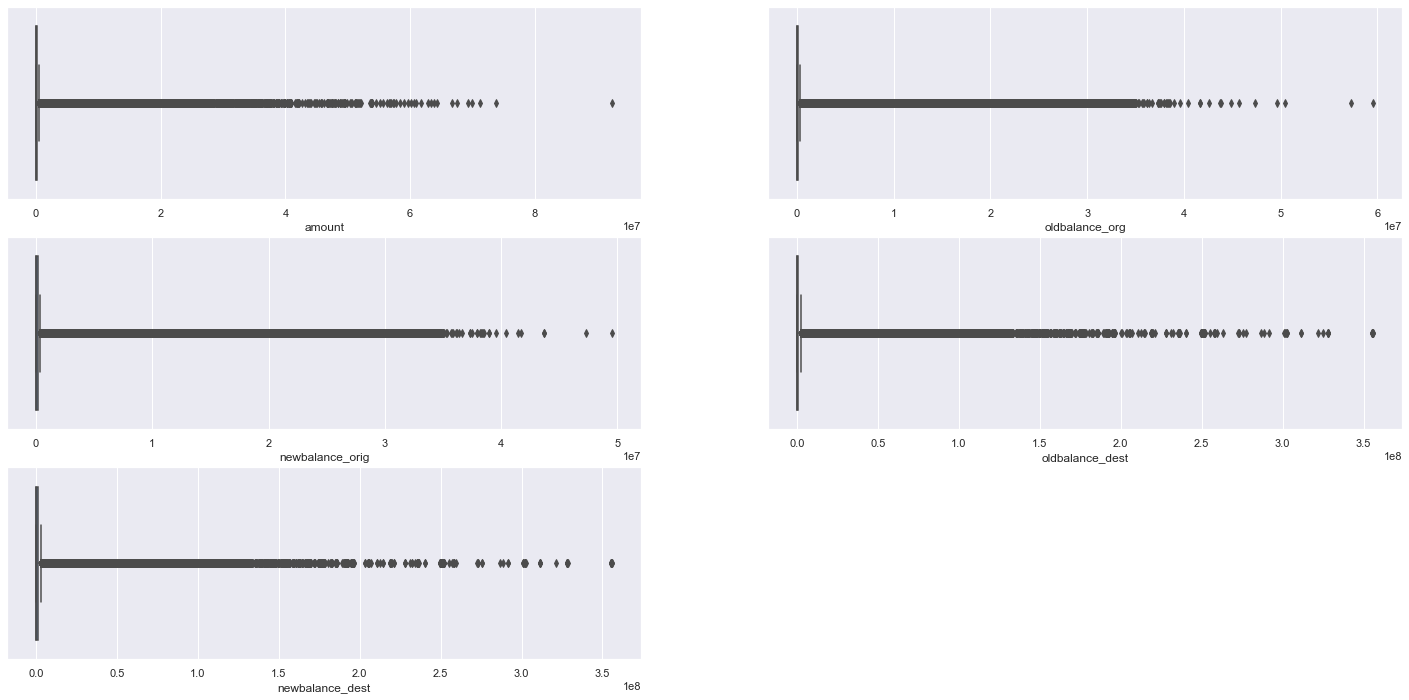

In [17]:
#Checking inconsistent variables

#amount
plt.subplot(3,2,1)
sns.boxplot(df1['amount'])

#oldbalance_org
plt.subplot(3,2,2)
sns.boxplot(df1['oldbalance_org'])

#newbalance_org
plt.subplot(3,2,3)
sns.boxplot(df1['newbalance_orig'])

#oldbalance_dest
plt.subplot(3,2,4)
sns.boxplot(df1['oldbalance_dest'])

#newbalance_dest
plt.subplot(3,2,5)
sns.boxplot(df1['newbalance_dest'])

<AxesSubplot:xlabel='step', ylabel='Density'>

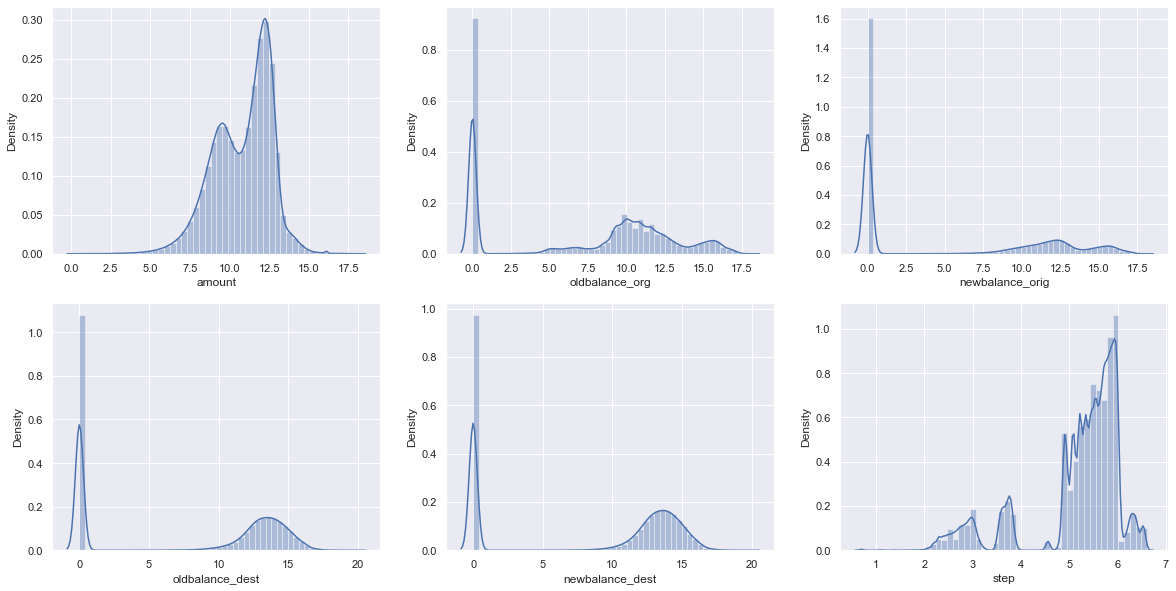

In [18]:
#normalized distribution plot

plt.figure(figsize = (20,10))

plt.subplot(2,3,1)
sns.distplot(np.log1p(num_attributes['amount']))  

plt.subplot(2,3,2)
sns.distplot(np.log1p(num_attributes['oldbalance_org']))

plt.subplot(2,3,3)
sns.distplot(np.log1p(num_attributes['newbalance_orig']))

plt.subplot(2,3,4)
sns.distplot(np.log1p(num_attributes['oldbalance_dest']))

plt.subplot(2,3,5)
sns.distplot(np.log1p(num_attributes['newbalance_dest']))

plt.subplot(2,3,6)
sns.distplot(np.log1p(df1['step']))

### 1.5.2. Categorical Attributes

In [19]:
cat_attributes.apply(lambda x: x.unique().shape[0])

type               5
name_orig    6353307
name_dest    2722362
dtype: int64

<AxesSubplot:xlabel='is_flagged_fraud', ylabel='count'>

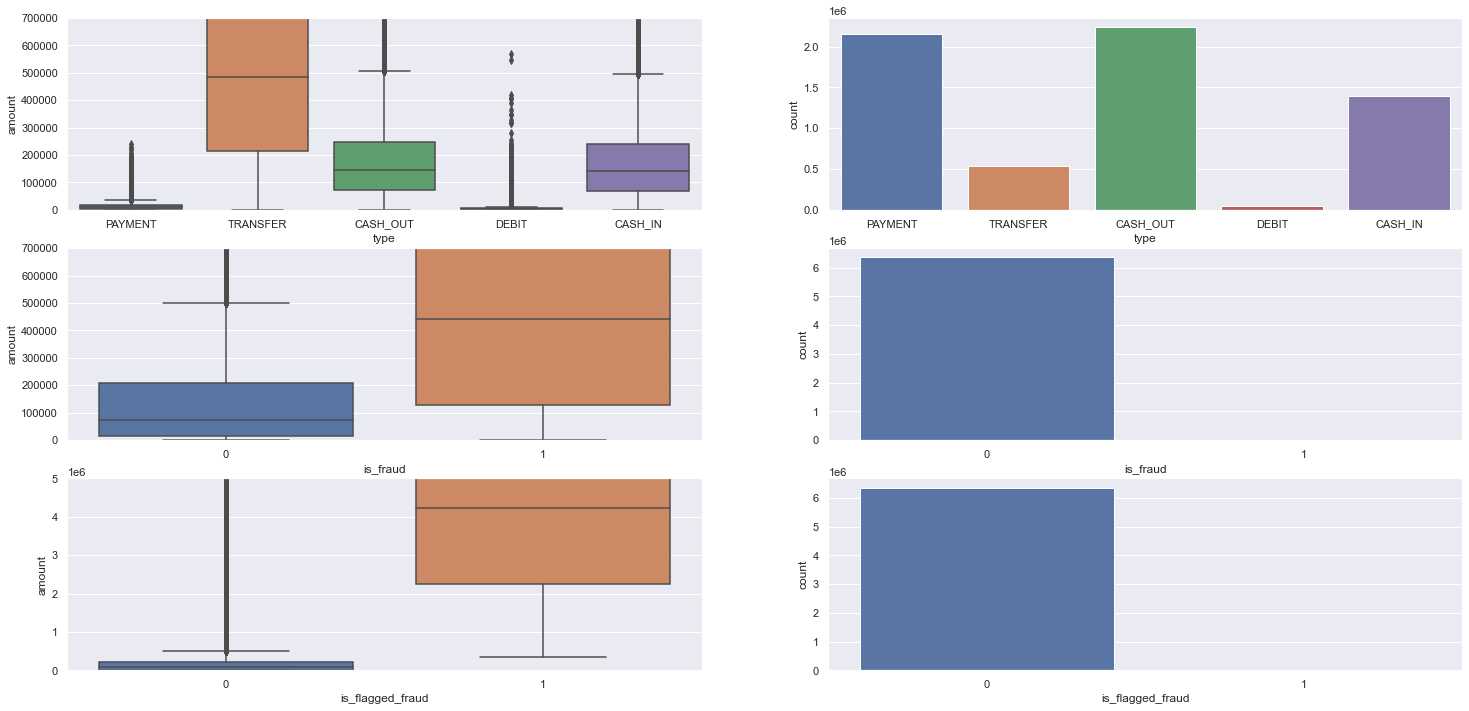

In [20]:
#boxplot to each variable

#type
plt.subplot(3,2,1)
sns.boxplot(x = 'type', y = 'amount', data = df1)
plt.ylim(0,700000)

plt.subplot(3,2,2)
sns.countplot(cat_attributes['type'])

#is_fraud
plt.subplot(3,2,3)
sns.boxplot(x = 'is_fraud', y = 'amount', data = df1)
plt.ylim(0,700000)

plt.subplot(3,2,4)
sns.countplot(df1['is_fraud'])

#is_flagged_fraud
plt.subplot(3,2,5)
sns.boxplot(x = 'is_flagged_fraud', y = 'amount', data = df1)
plt.ylim(0,5000000)

plt.subplot(3,2,6)
sns.countplot(df1['is_flagged_fraud'])

In [21]:
#is_fraud feature
print(df1['is_fraud'].value_counts(normalize = True))

#is_flagged_fraud feature
print(df1['is_flagged_fraud'].value_counts(normalize = True))

0    0.998709
1    0.001291
Name: is_fraud, dtype: float64
0    0.999997
1    0.000003
Name: is_flagged_fraud, dtype: float64


# 2.0. FEATURE ENGINEERING

In [22]:
df2 = df1.copy()

## 2.1. Hypothesis MindMap 

![image](hypothesesMindMap.png)

## 2.2. Hypothesis List

**H1** - High value transactions are more likely to be defrauded.
    
**H2** - There are more cases of transfer fraud than other types of transactions fraud.

**H3** - The probability of fraud is low when the original balance is zero.

**H4** - The probability of fraud is high when the final balance is zero.
    
**H5** - Frauds happen more frequently among customers than among merchants.

**H6** - Transactions over $ 200,000.00 are always fraudulent.

**H7** - Frauds happen more frequently in the first 15 days of the month.

## 2.3. Feature Engineering

In [23]:
#error balance origin 
df2['error_balance_orig'] = np.round((df2['newbalance_orig'] + df2['amount'] - df2['oldbalance_org']),2)

#error balance destination
df2['error_balance_dest'] = df2['newbalance_dest'] + df2['amount'] - df2['oldbalance_dest']

#flow origin
df2['flow_orig'] = df2['newbalance_orig'] - df2['oldbalance_org']

#flow destination
df2['flow_dest'] = df2['newbalance_dest'] - df2['oldbalance_dest']

#create client origin and destination id
df2['client_dest'] = df2['name_dest'].apply(lambda x: "Merchant" if "M" in x else "Costumer")
df2['client_orig'] = df2['name_orig'].apply(lambda x: 'Merchant' if "M" in x else "Costumer")

#transform step time in days 
df2['day'] = df2['step'].apply(lambda x: int(x/24))

#week of the month (1 to 5)
df2['week_of_month'] = df2['day'].apply(lambda x: 1 if (x <=7) else 2 if (x <= 14) & (x>7) else 3 if (x > 14) & (x<=21) else 4)

#is weekend
df2['weekend'] = df2['day'].apply(lambda x: 1 if (x == 7) or (x == 6) or (x == 14) or (x == 13) or (x == 20) or (x == 21) or (x == 27) or (x == 28) else 0)

In [24]:
df2.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,error_balance_orig,error_balance_dest,flow_orig,flow_dest,client_dest,client_orig,day,week_of_month,weekend
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0.0,9839.64,-9839.64,0.0,Merchant,Costumer,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0.0,1864.28,-1864.28,0.0,Merchant,Costumer,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0.0,181.00,-181.00,0.0,Costumer,Costumer,0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0.0,-21001.00,-181.00,-21182.0,Costumer,Costumer,0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0.0,11668.14,-11668.14,0.0,Merchant,Costumer,0,1,0


# 3.0. DATA FILTERING

In [25]:
df3 = df2.copy()

## 3.1. Filtering Columns

In [26]:
#removing features
df3.drop(columns = ['name_orig','name_dest'], axis = 1, inplace = True)

## 3.2. Filtering Rows

<AxesSubplot:>

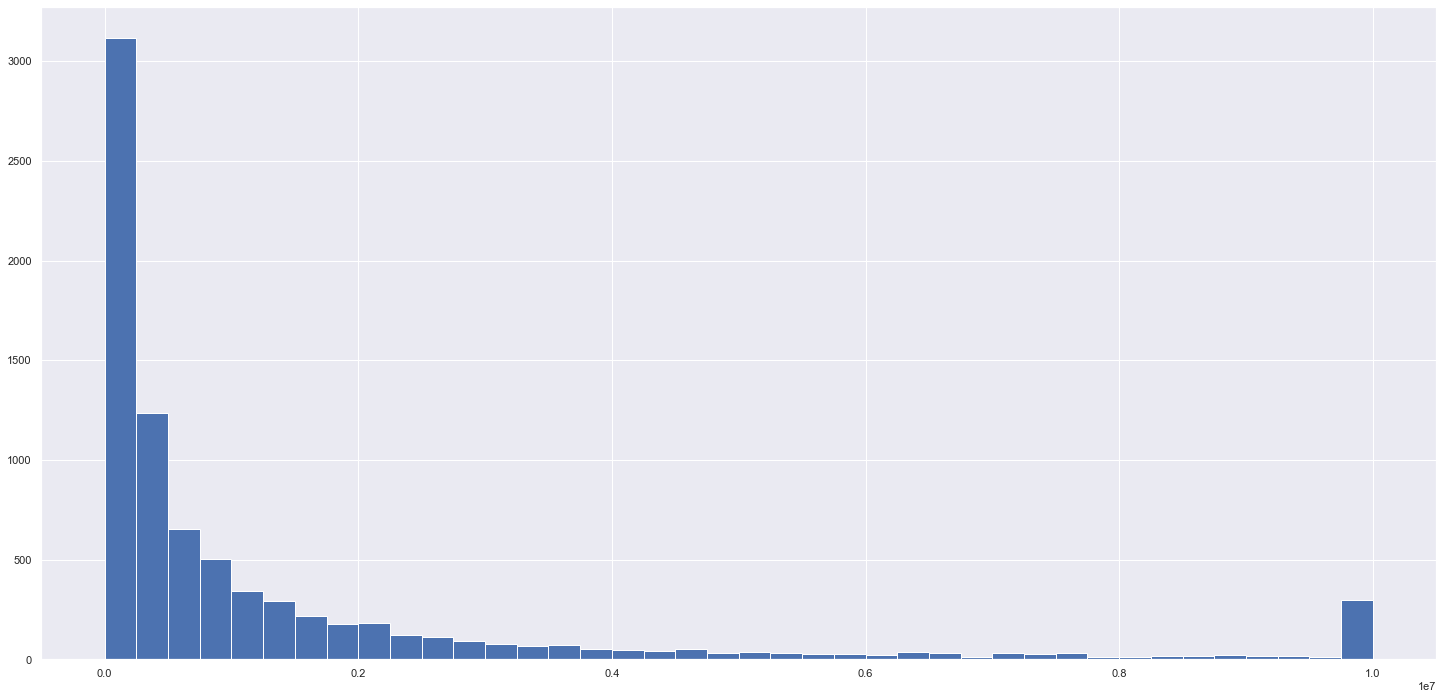

In [27]:
df3_aux=df3[df3["is_fraud"] == 1]
df3_aux["amount"].hist(bins=40)

<AxesSubplot:xlabel='day', ylabel='amount'>

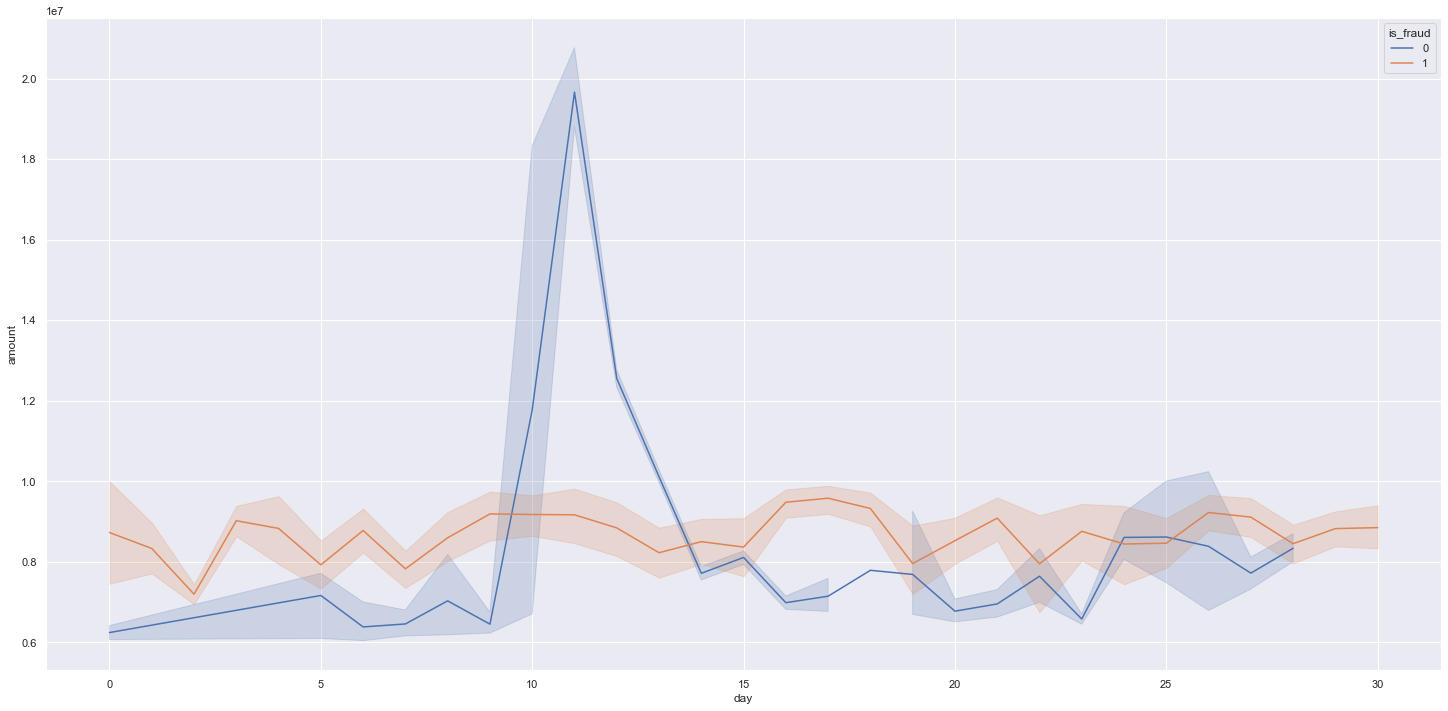

In [28]:
df3_aux2=df3[df3["amount"] > 6000000]
a=df3_aux2["amount"].groupby(df3_aux2["is_fraud"]).sum()
sns.lineplot(x="day",y="amount", hue="is_fraud", data=df3_aux2)

# 4.0. EXPLORATORY DATA ANALYSIS

In [29]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

(0.0, 4000000.0)

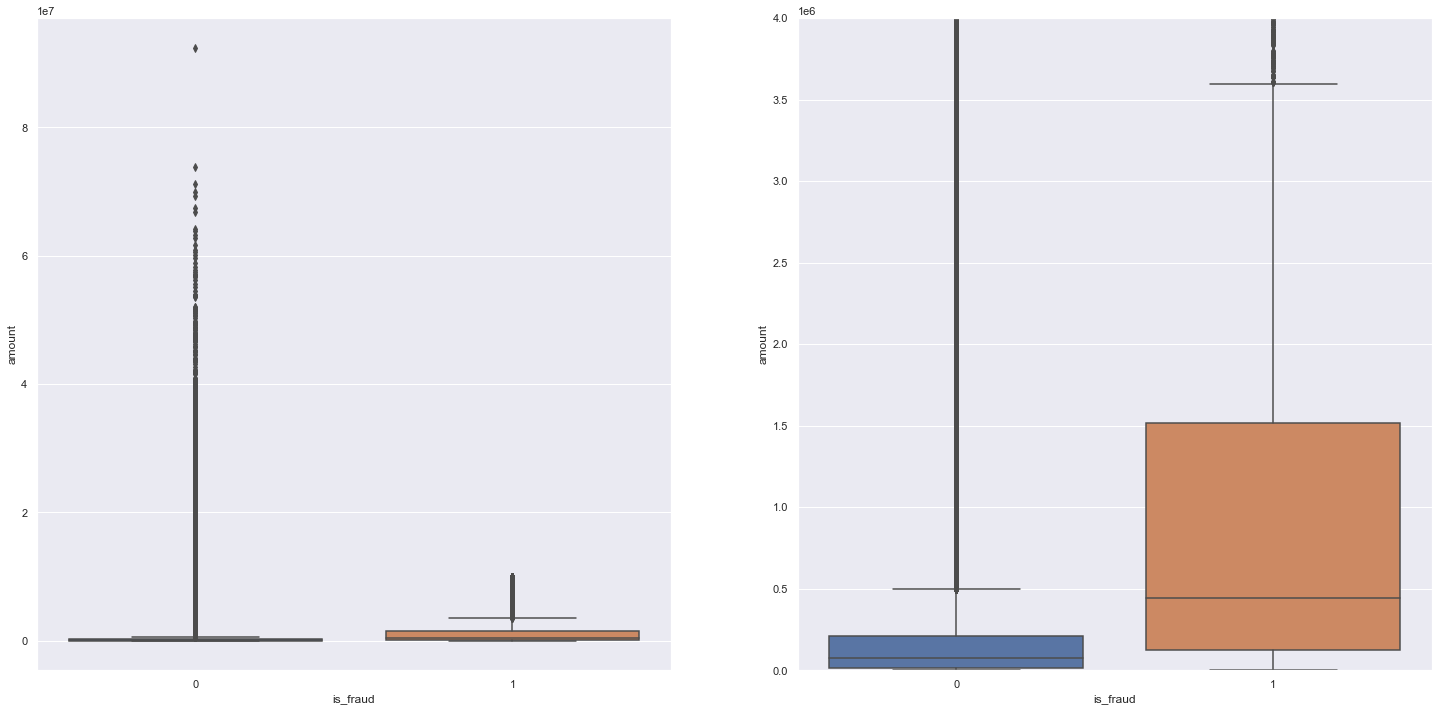

In [30]:
#ploting is_fraud feature
plt.subplot(1,2,1)
sns.boxplot(x = 'is_fraud', y = 'amount', data = df1)

plt.subplot(1,2,2)
sns.boxplot(x = 'is_fraud', y = 'amount', data = df1)
plt.ylim(0,4000000)

In [31]:
#filtering response variable
df4=df4[df4["amount"]<4000000]

In [32]:
#check proportion
is_fraud_list = [(df4[df4['is_fraud'] == 1].shape[0]/df4.shape[0])*100, (df4[df4['is_fraud'] == 0].shape[0]/df4.shape[0])*100]
df_fraud = pd.DataFrame(is_fraud_list).T
df_fraud.columns = ['Positive','Negative']
df_fraud

,Positive,Negative
0,0.115051,99.884949


### 4.1.2. Numerical Variables

<Figure size 1440x1440 with 0 Axes>

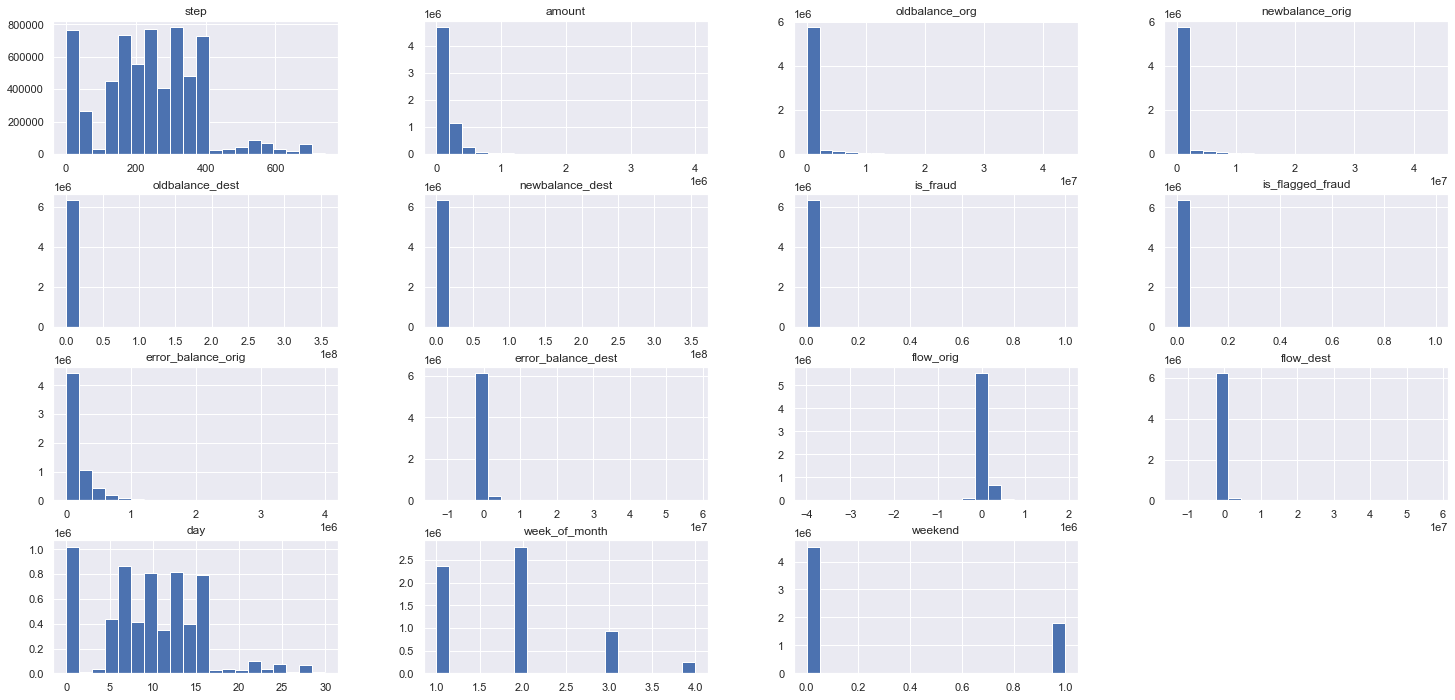

In [33]:
num_attributes = df4.select_dtypes(include = ['int64','float64'])
plt.figure(figsize = (20,20))
num_attributes.hist(bins=20);

### 4.1.3. Categorical Variables

In [34]:
cat_attributes = df4.select_dtypes(include = 'object')
cat_attributes.head()

,type,client_dest,client_orig
0,PAYMENT,Merchant,Costumer
1,PAYMENT,Merchant,Costumer
2,TRANSFER,Costumer,Costumer
3,CASH_OUT,Costumer,Costumer
4,PAYMENT,Merchant,Costumer


<AxesSubplot:xlabel='type', ylabel='count'>

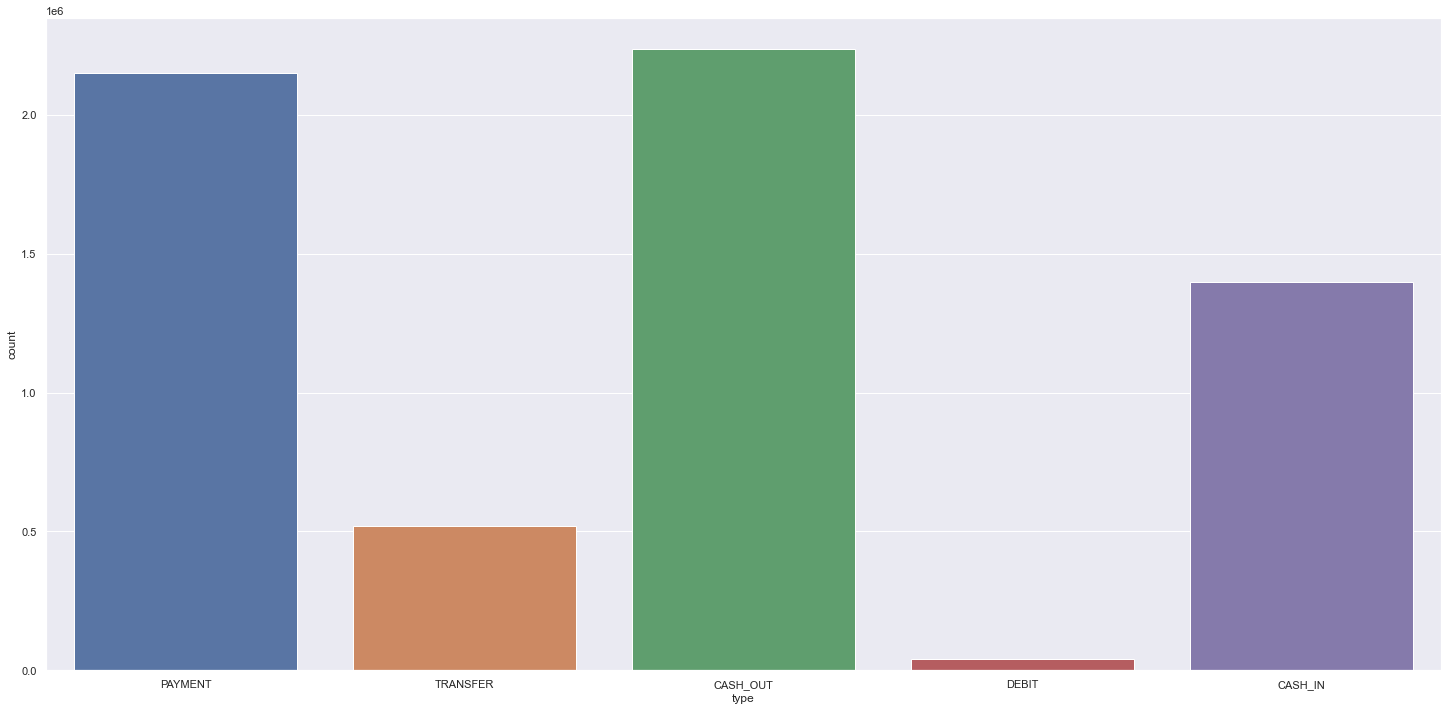

In [35]:
#type
sns.countplot(cat_attributes['type'])

<AxesSubplot:xlabel='client_orig', ylabel='count'>

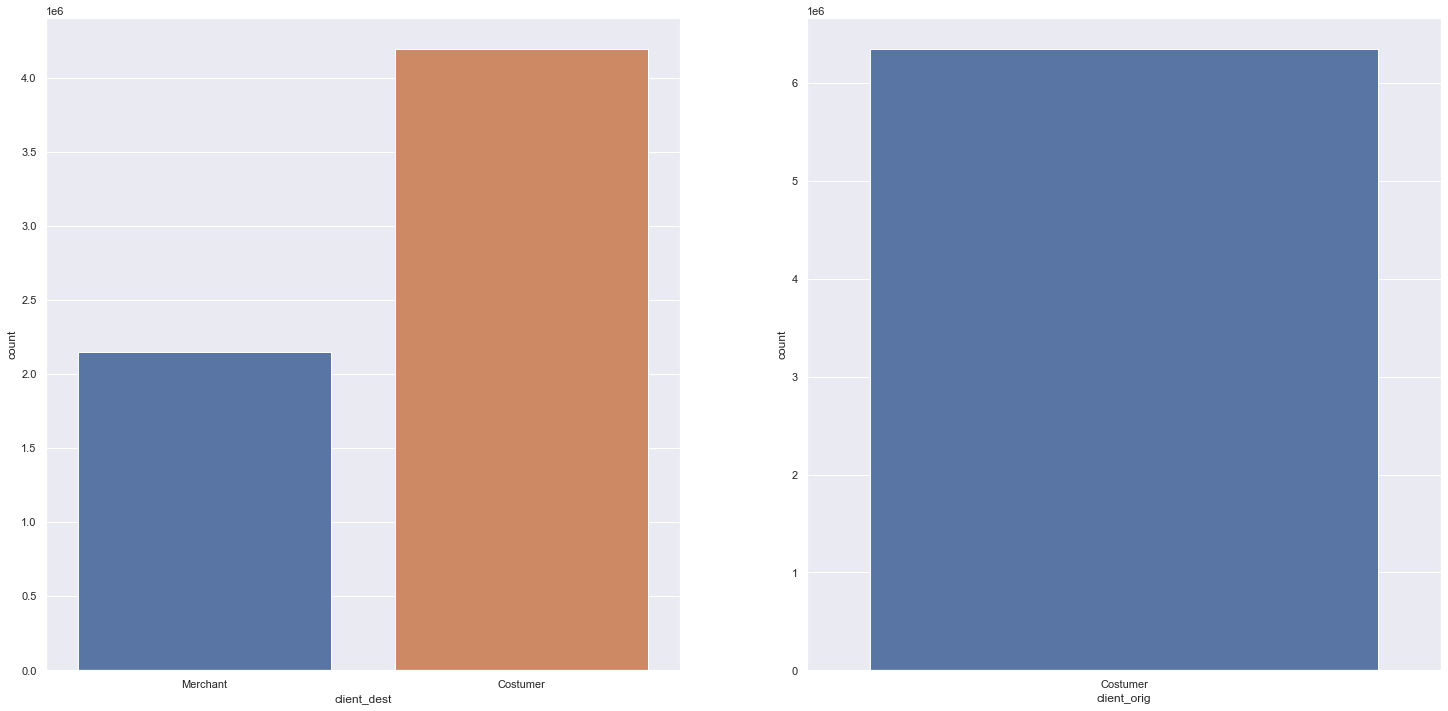

In [36]:
#client_dest
plt.subplot(1,2,1)
sns.countplot(cat_attributes['client_dest'])

#client_orig
plt.subplot(1,2,2)
sns.countplot(cat_attributes['client_orig'])

## 4.2. Bivariate Analysis

### H1. High value transactions are more likely to be defrauded

Text(0.5, 1.0, 'Days x Amount')

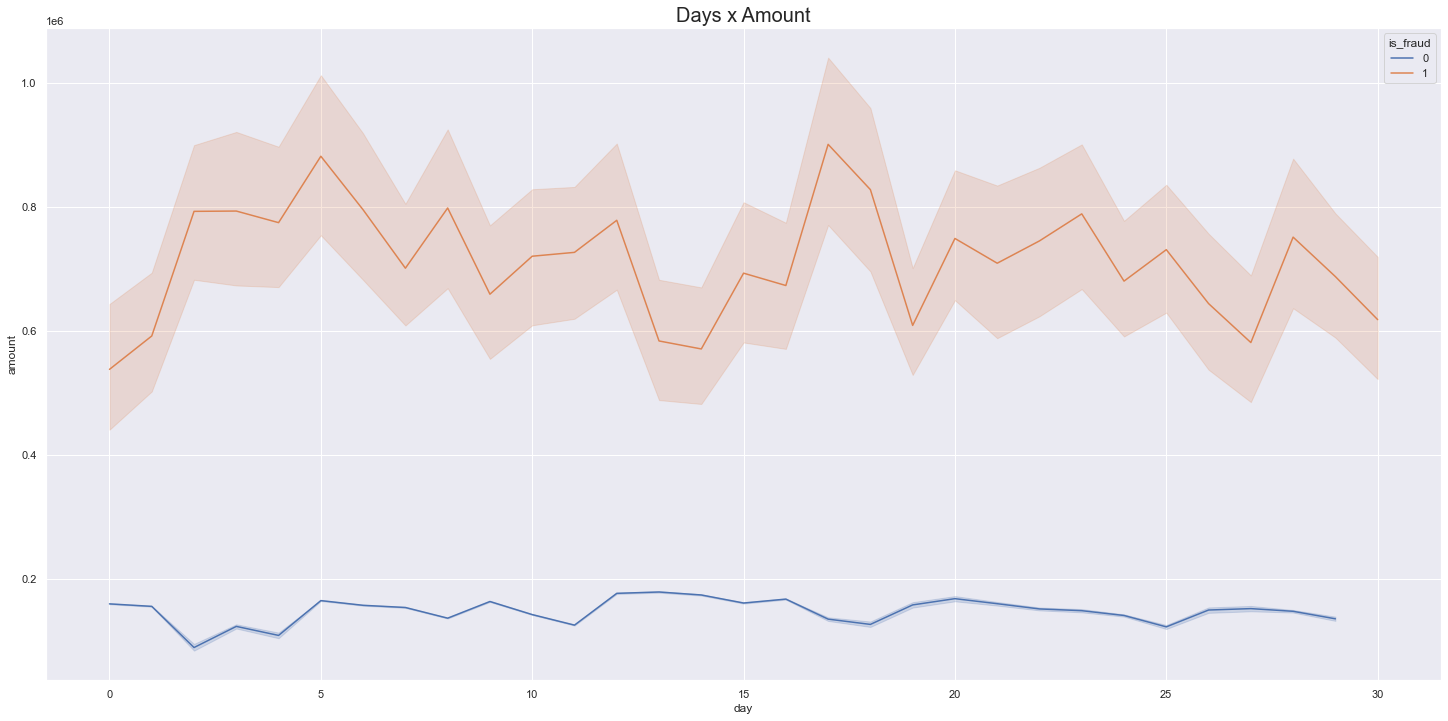

In [46]:
#plot days x amount 
sns.lineplot(x = 'day', y = 'amount', hue = 'is_fraud', data = df4)
plt.title("Days x Amount", fontsize = 20)

Text(0.5, 1.0, 'Is Fraud')

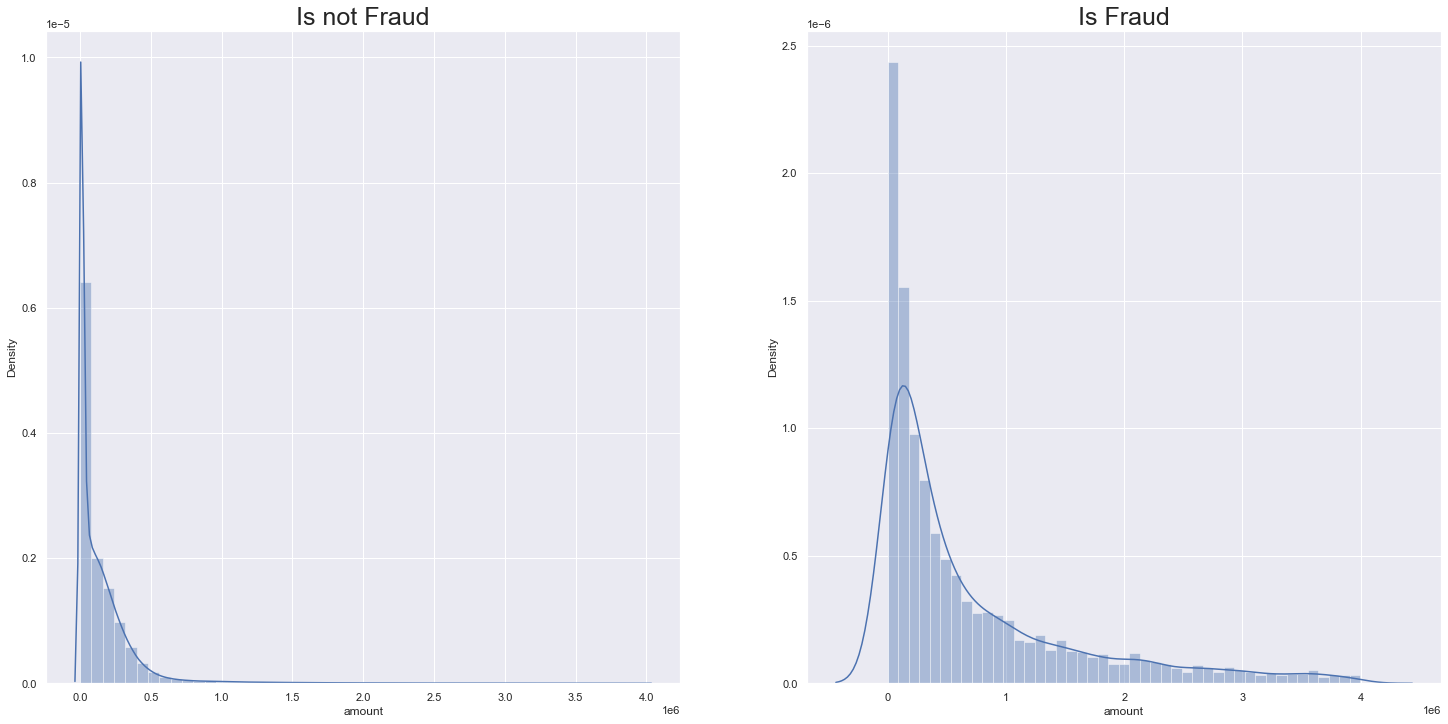

In [47]:
#histogram

#is not fraud
plt.subplot(1,2,1)
aux0 = df4[df4['is_fraud'] == 0]
sns.distplot(aux0['amount'])
plt.title("Is not Fraud", fontsize = 25)

#is fraud
plt.subplot(1,2,2)
aux1 = df4[df4['is_fraud'] == 1]
sns.distplot(aux1['amount'], kde = True)
plt.title("Is Fraud", fontsize = 25)

<AxesSubplot:xlabel='day', ylabel='amount'>

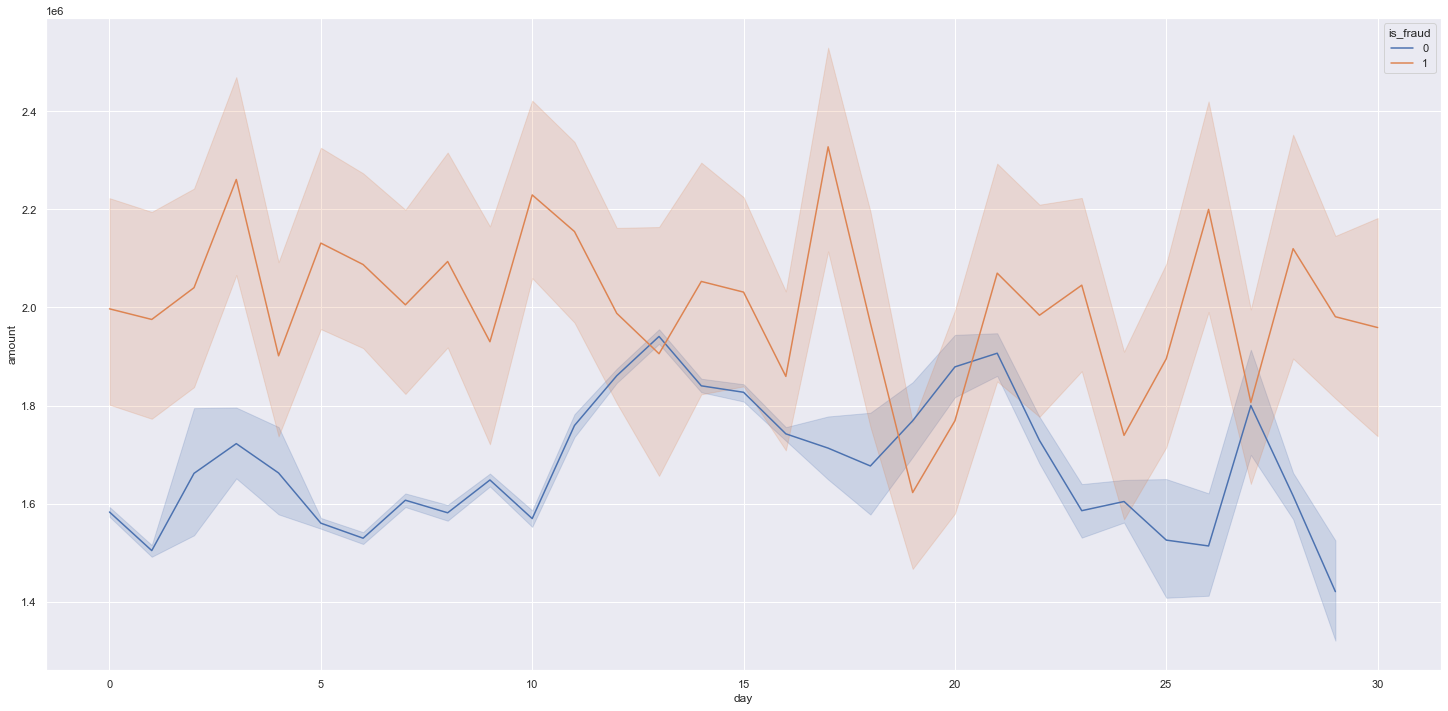

In [52]:
#amount greater than 1 million
aux=df4[df4["amount"]>1000000]
sns.lineplot(x = 'day', y = 'amount', hue = 'is_fraud', data = aux)

In [49]:
#correlation
aux= df4[['is_fraud','amount']]
aux.corr(method = 'pearson')

,is_fraud,amount
is_fraud,1.000000,0.067783
amount,0.067783,1.000000


### H2. There are more cases of transfer fraud than other types of transactions fraud

<AxesSubplot:xlabel='type', ylabel='amount'>

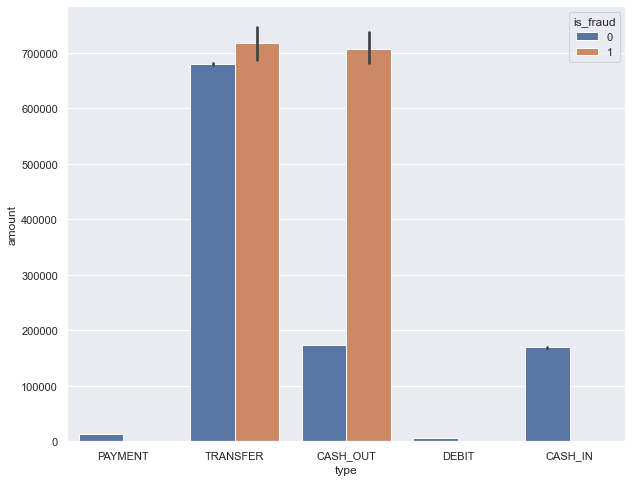

In [50]:
#types of transactions
plt.figure(figsize = (10,8))
sns.barplot(x = 'type', y = 'amount', hue = 'is_fraud', data = df4)

Text(0.5, 1.0, 'Only Fraudulent')

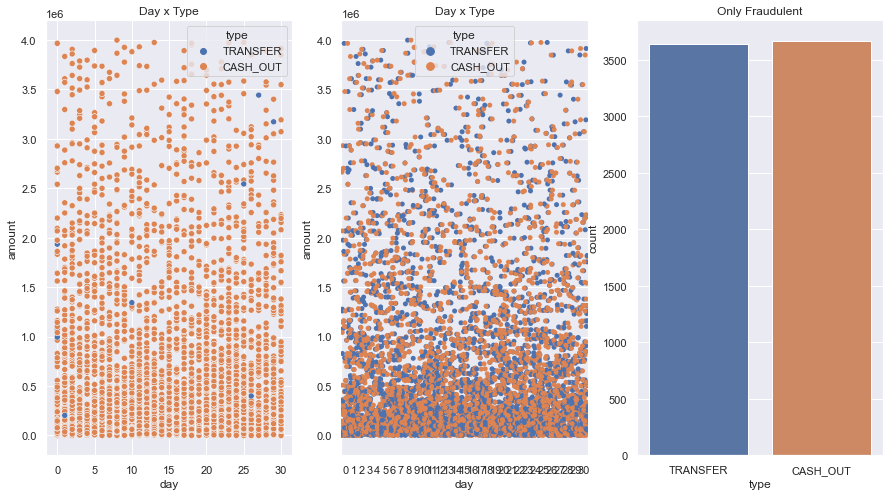

In [51]:
#types of fraudulent transactions
plt.figure(figsize = (15,8))

plt.subplot(1,3,1)
sns.scatterplot(x = 'day', y = 'amount', hue = 'type', data = aux1)
plt.title("Day x Type")

plt.subplot(1,3,2)
sns.stripplot(x = 'day', y = 'amount', hue = 'type', jitter=0.5, data = aux1)
plt.title("Day x Type")

plt.subplot(1,3,3)
sns.countplot(aux1['type'])
plt.title("Only Fraudulent")

### H3. The probability of fraud is low when the original balance is zero

<AxesSubplot:xlabel='oldbalance_org', ylabel='amount'>

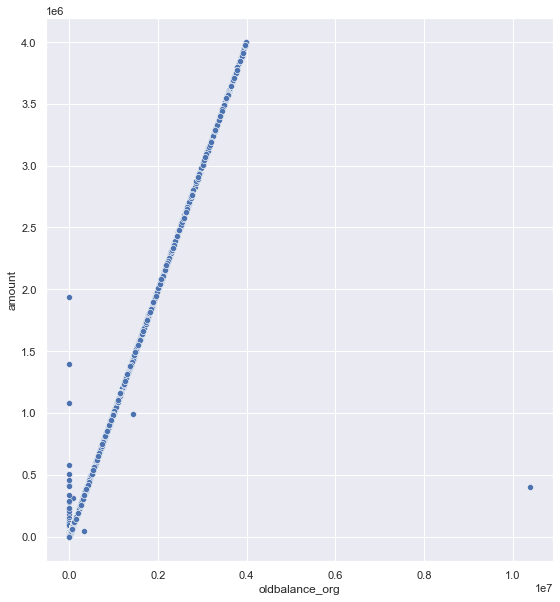

In [53]:
#day x oldbalance_org - fraudulent transactions
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
sns.scatterplot(x = 'oldbalance_org', y = 'amount', data = aux1)

In [54]:
#oldbalance_org data
aux2=aux1[(aux1["oldbalance_org"]==0)]
aux2.head()

,step,type,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,error_balance_orig,error_balance_dest,flow_orig,flow_dest,client_dest,client_orig,day,week_of_month,weekend
724,1,CASH_OUT,416001.33,0.0,0.0,102.00,9291619.62,1,0,416001.33,9707518.95,0.0,9291517.62,Costumer,Costumer,0,1,0
14861,8,CASH_OUT,181728.11,0.0,0.0,11397.00,184477.77,1,0,181728.11,354808.88,0.0,173080.77,Costumer,Costumer,0,1,0
25875,8,TRANSFER,1078013.76,0.0,0.0,0.00,970749.68,1,0,1078013.76,2048763.44,0.0,970749.68,Costumer,Costumer,0,1,0
77745,10,CASH_OUT,277970.88,0.0,0.0,0.00,277970.88,1,0,277970.88,555941.76,0.0,277970.88,Costumer,Costumer,0,1,0
138559,11,TRANSFER,1933920.80,0.0,0.0,1283762.85,3217683.65,1,0,1933920.80,3867841.60,0.0,1933920.80,Costumer,Costumer,0,1,0


In [56]:
#correlation
aux3= df4[['is_fraud','oldbalance_org']]
aux3.corr(method = 'pearson')

,is_fraud,oldbalance_org
is_fraud,1.000000,-0.001436
oldbalance_org,-0.001436,1.000000


### **H4**. The probability of fraud is high when the final balance is zero

<AxesSubplot:xlabel='is_fraud', ylabel='amount'>

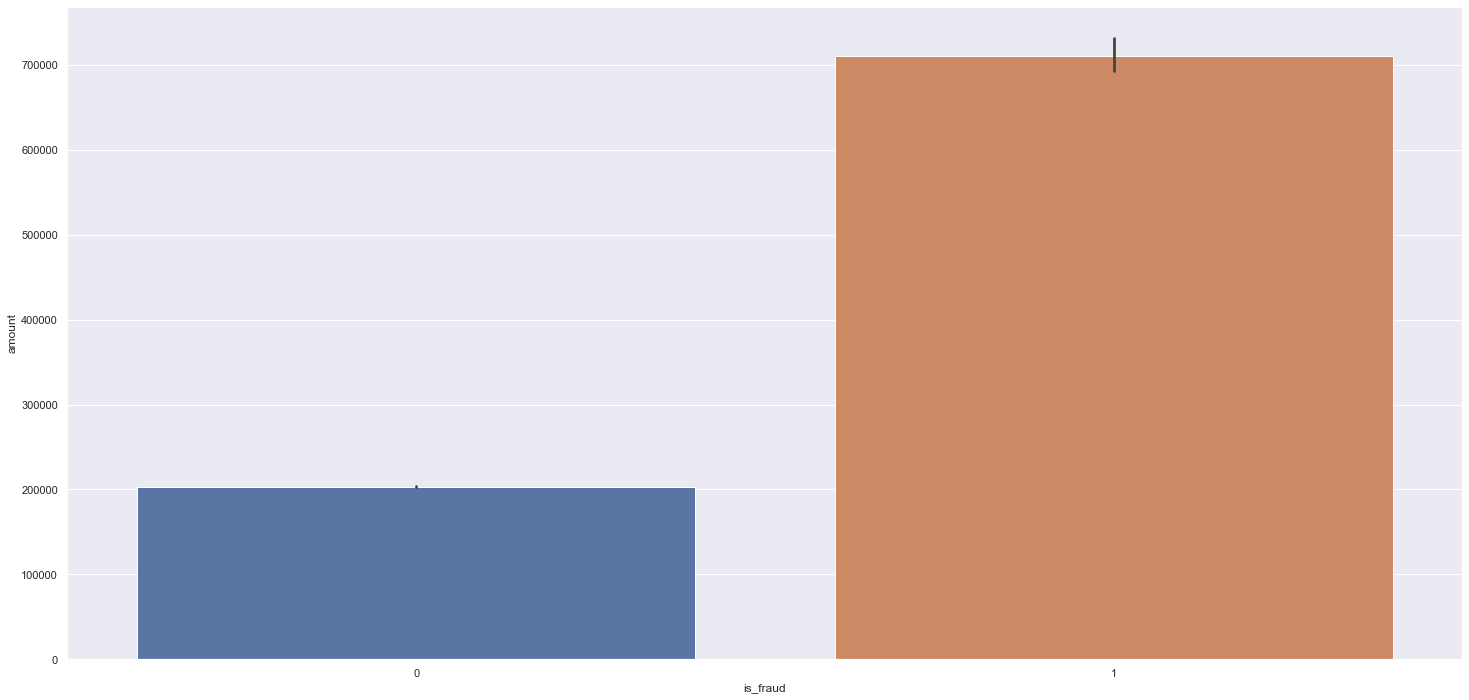

In [57]:
#type of transactions when final balance is zero
aux4=df4[(df4["newbalance_orig"]==0)]
sns.barplot(x = 'is_fraud', y = 'amount', data = aux4)

In [58]:
#count - numer of transactions 
aux4[['is_fraud']].groupby('is_fraud').size()

is_fraud
0    3587403
1       7293
dtype: int64

In [59]:
#percentage of transactions
aux0=df4[(df4['is_fraud'] == 0)]
df_new_balance_orig = pd.DataFrame([aux1[aux1['newbalance_orig'] == 0].shape[0]/aux1.shape[0], aux0[aux0['newbalance_orig'] == 0].shape[0]/aux0.shape[0]]).T
df_new_balance_orig.columns = ['Fraudulent','Non-Fraudulent']
df_new_balance_orig

,Fraudulent,Non-Fraudulent
0,0.998631,0.56581


In [60]:
#correlation
aux5= df4[['is_fraud','newbalance_orig']]
print(aux5.corr(method = 'pearson'))

aux6= aux4[['is_fraud','amount']]
print(aux6.corr(method = 'pearson'))

                 is_fraud  newbalance_orig
is_fraud         1.000000        -0.009896
newbalance_orig -0.009896         1.000000
          is_fraud    amount
is_fraud  1.000000  0.066085
amount    0.066085  1.000000


### H5.  Frauds happen more frequently among customers than among merchants

<AxesSubplot:xlabel='client_dest', ylabel='count'>

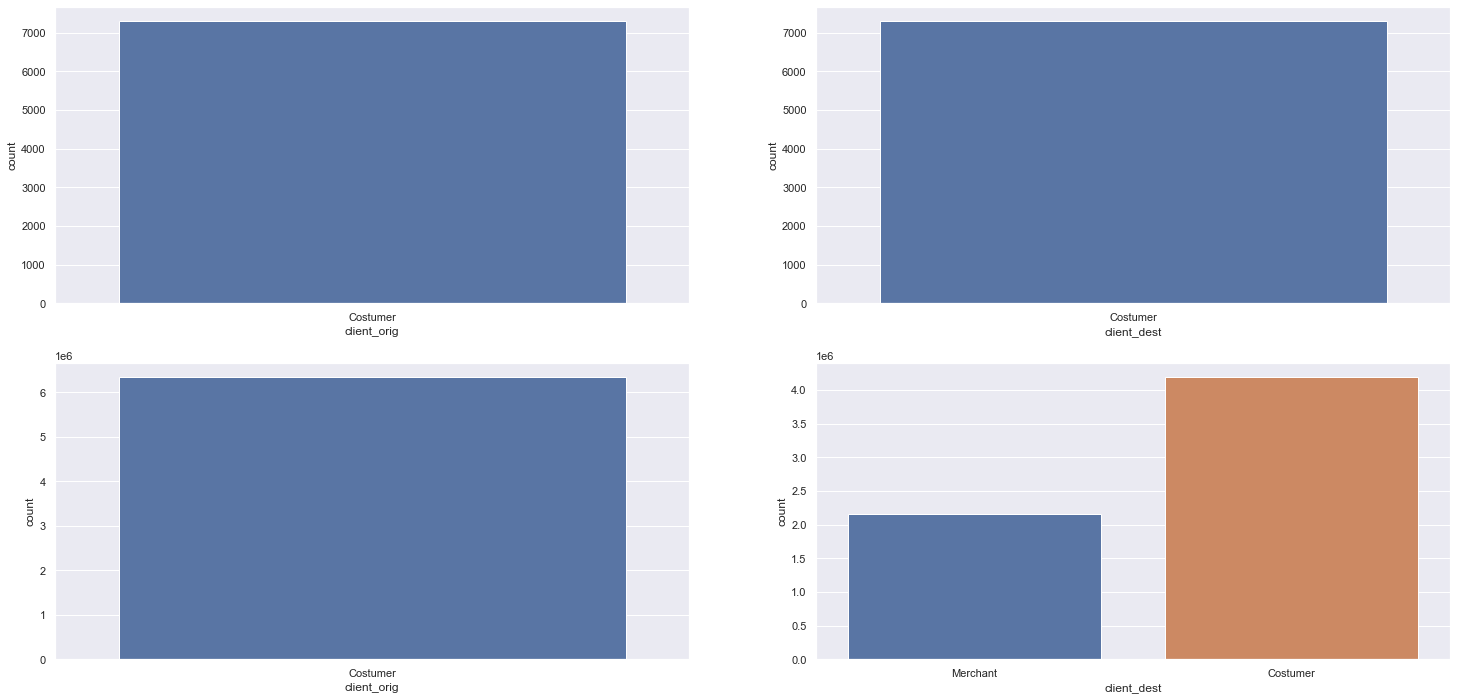

In [68]:
#when its fraud
plt.subplot(2,2,1)
sns.countplot(aux1['client_orig'])

plt.subplot(2,2,2)
sns.countplot(aux1['client_dest'])

#in general
plt.subplot(2,2,3)
sns.countplot(df4['client_orig'])

plt.subplot(2,2,4)
sns.countplot(df4['client_dest'])

In [69]:
#origin-destination type count
aux7 = df4[['client_orig', 'client_dest','is_fraud']].groupby(["is_fraud",'client_orig','client_dest']).size().reset_index()
aux7

,is_fraud,client_orig,client_dest,0
0,0,Costumer,Costumer,4188801
1,0,Costumer,Merchant,2151495
2,1,Costumer,Costumer,7303


### H6.  Transactions over $ 200,000.00 are always fraudulent

<AxesSubplot:xlabel='is_fraud', ylabel='amount'>

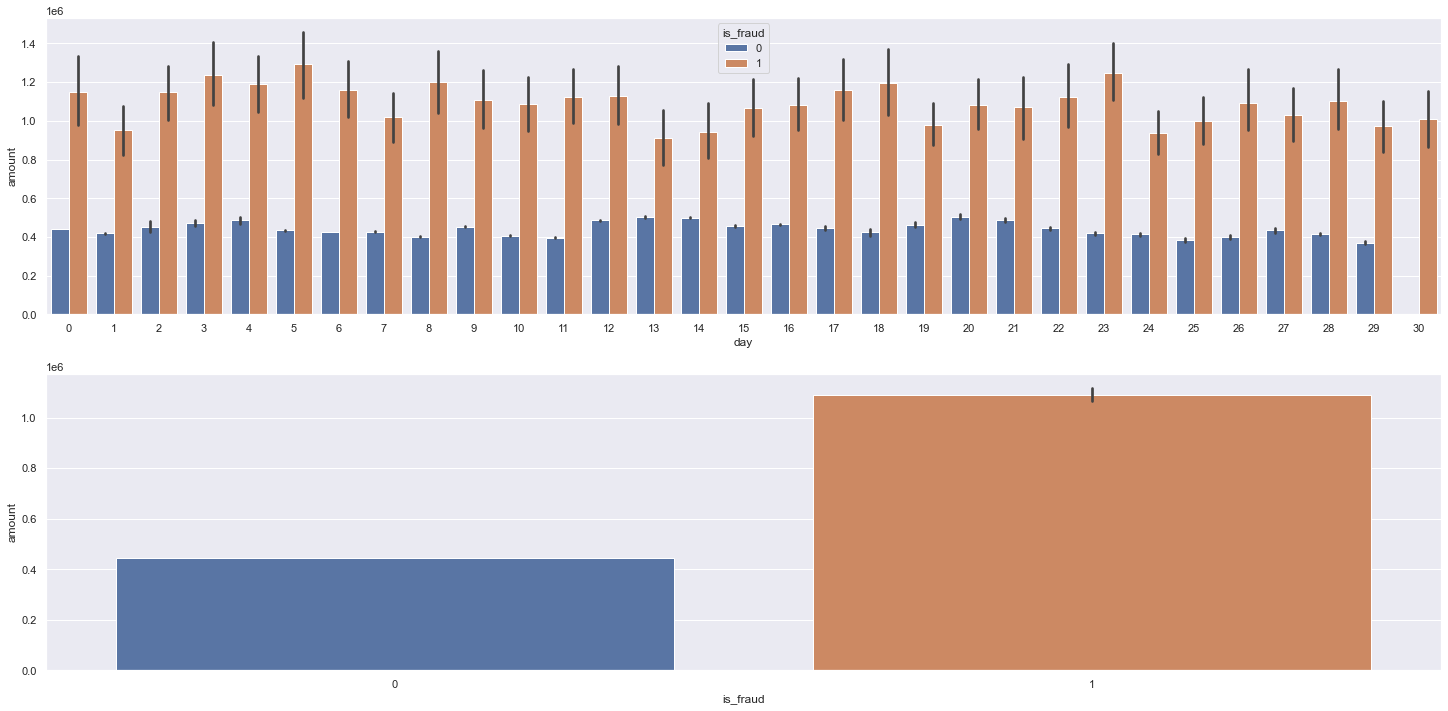

In [72]:
#amount greater than 20,000
aux8 = df4[df4['amount'] > 200000]

plt.subplot(2,1,1)
sns.barplot(x = 'day', y = 'amount', hue = 'is_fraud', data = aux8)
plt.subplot(2,1,2)
sns.barplot(x = 'is_fraud', y = 'amount', data = aux8)

In [71]:
#type count
aux8[['is_fraud']].groupby('is_fraud').size()

is_fraud
0    1653988
1       4561
dtype: int64

### **H7** - Frauds happen more frequently in the first 15 days of the month

Text(0.5, 1.0, 'Fraud by Day')

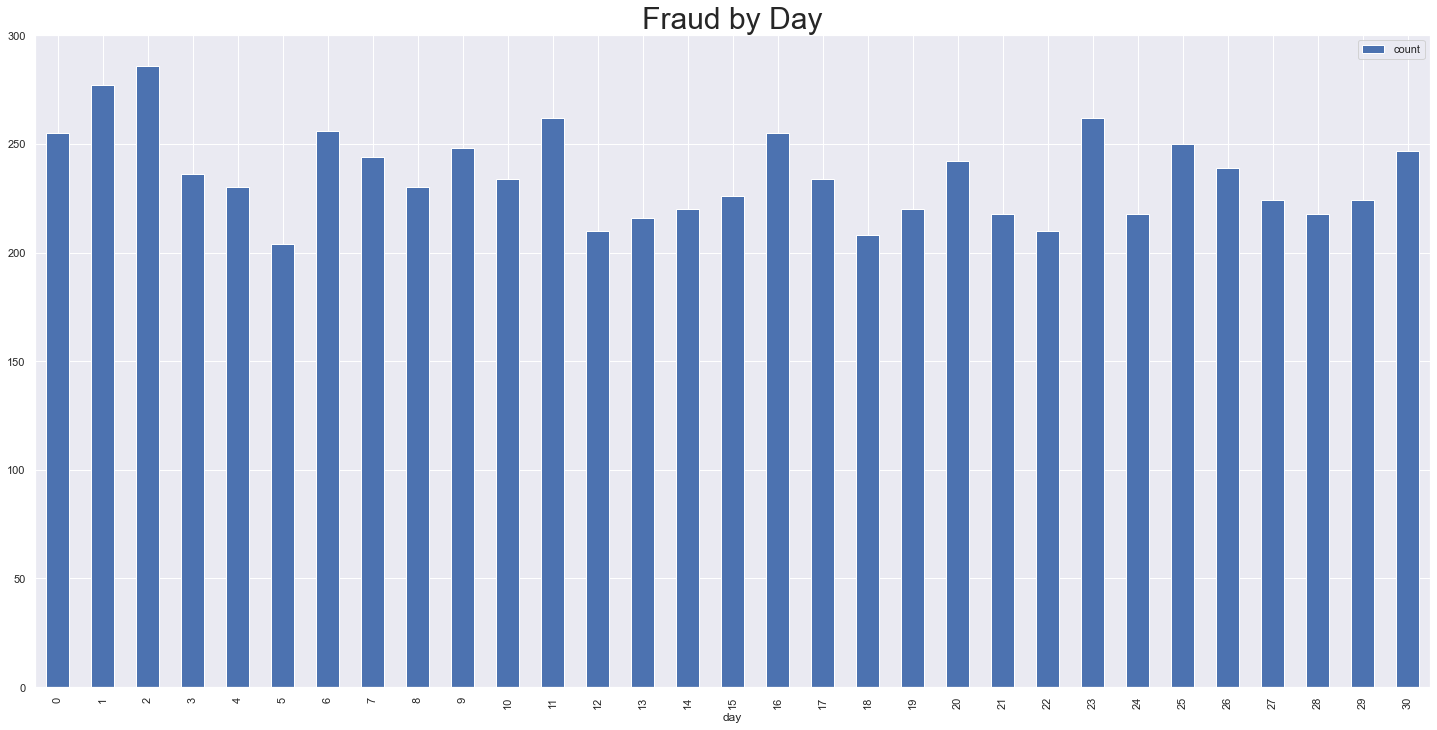

In [73]:
#fradulent transactions by month day
aux9 = aux1[['is_fraud','day']].groupby("day").size().reset_index()
aux9.columns=["day","count"]

aux9.plot.bar(x = 'day', y = 'count')
plt.title("Fraud by Day", fontsize = 30)

<AxesSubplot:xlabel='day', ylabel='count'>

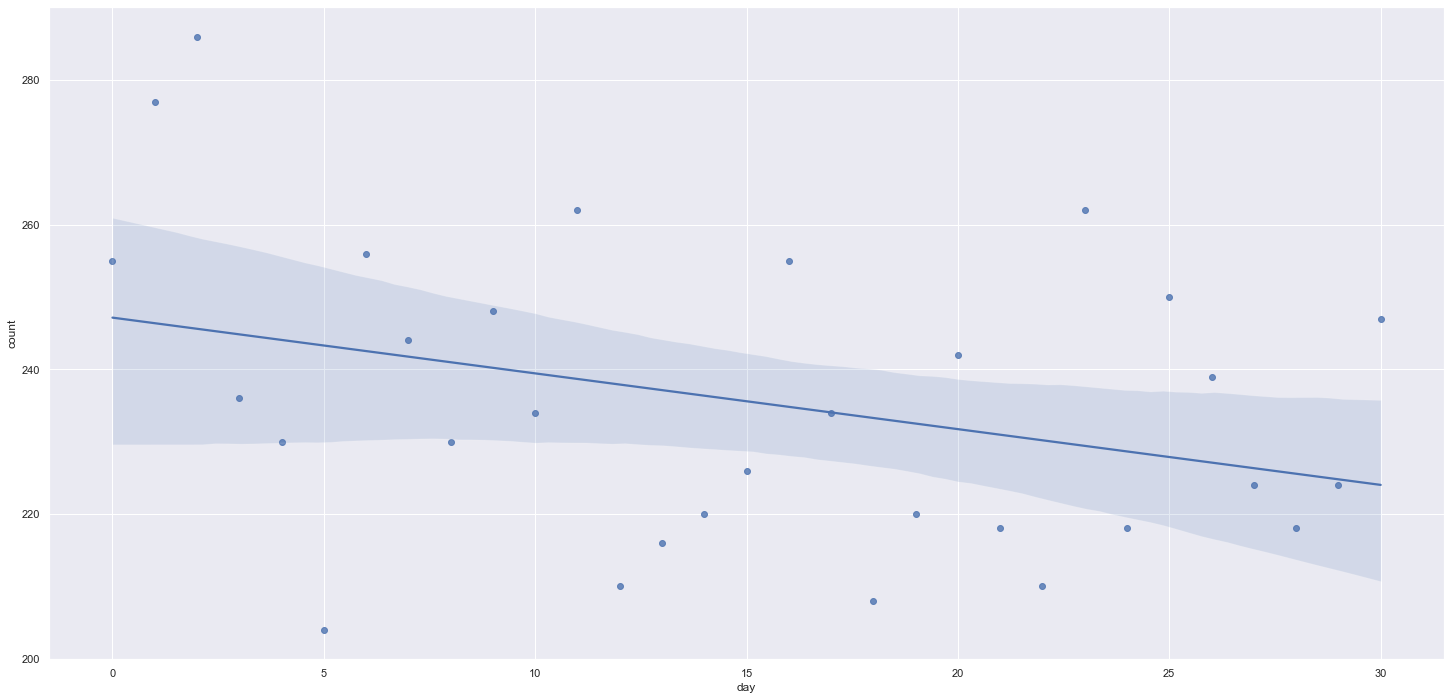

In [74]:
#regression plot
sns.regplot(x = 'day',y = 'count', data = aux9)

In [75]:
#correlation
aux11= df4[['is_fraud','day']]
aux11.corr(method = 'pearson')

,is_fraud,day
is_fraud,1.000000,0.030044
day,0.030044,1.000000


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

<AxesSubplot:>

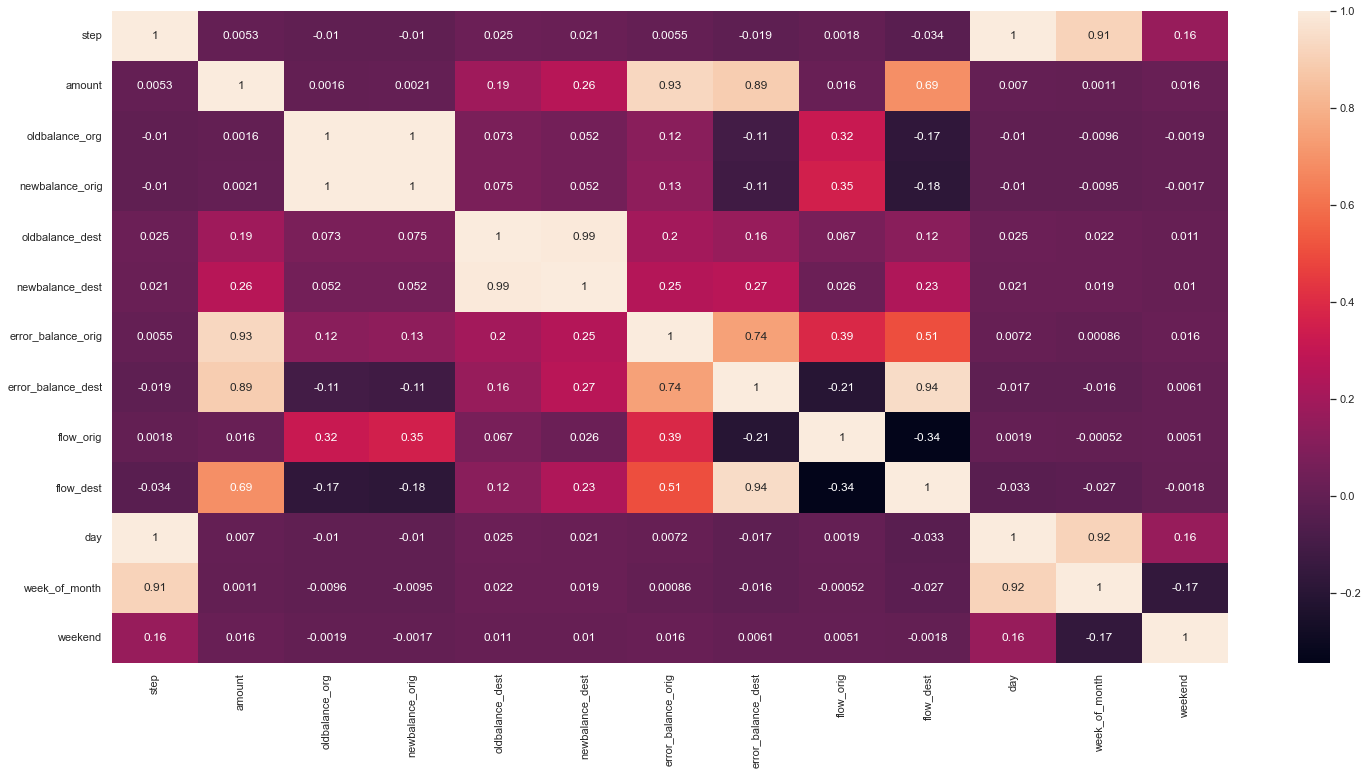

In [76]:
#selecting num_attributes to check the multivariate correlation
num_attributes = df4.select_dtypes(include = ['int','float'])
num_attributes.drop(columns = ['is_fraud','is_flagged_fraud'], axis = 1, inplace = True)
sns.heatmap(num_attributes.corr(method = 'pearson'), annot = True)

In [77]:
#transforming type variable in a numerical attribute
aux12=df4.copy()
le = LabelEncoder()
aux12['type'] = le.fit_transform(df4['type'])

<AxesSubplot:>

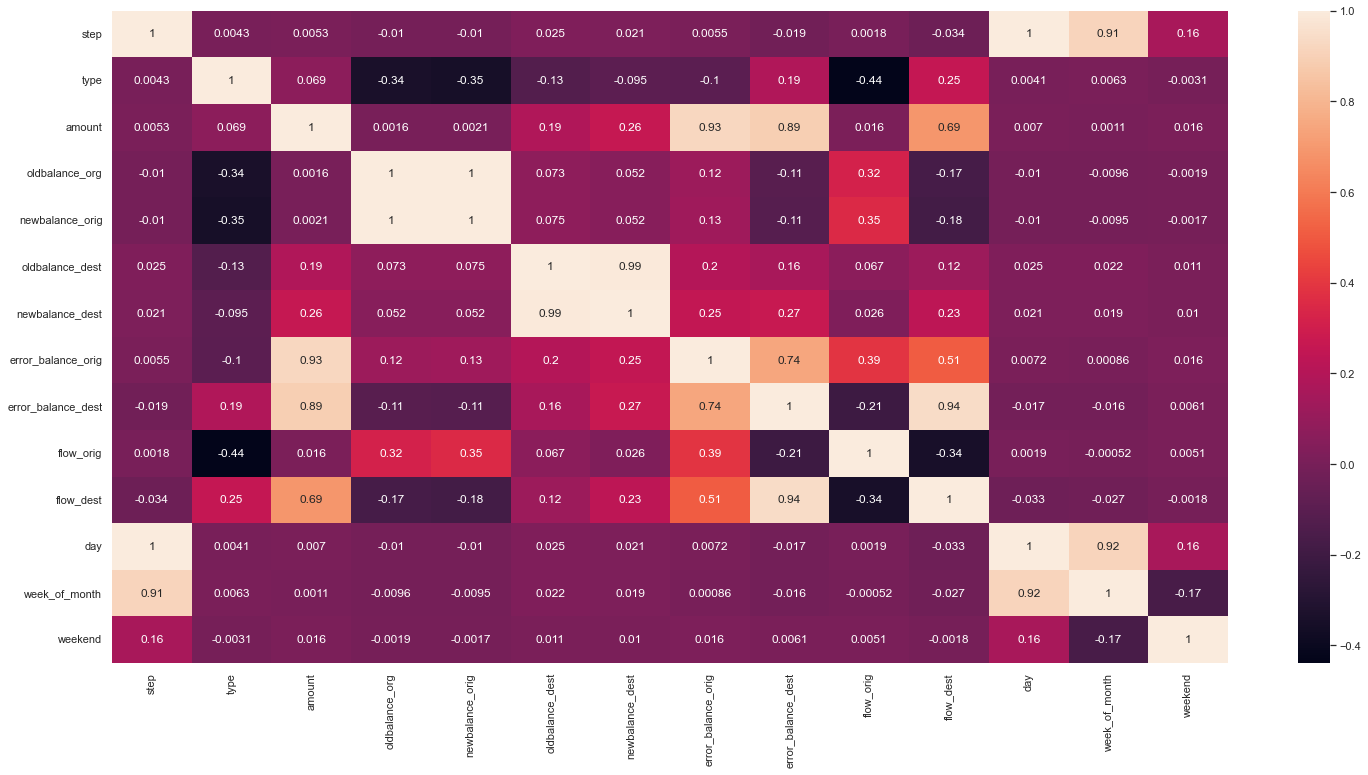

In [78]:
#selecting num_attributes to check the multivariate correlation
num_attributes2 = aux12.select_dtypes(include = ['int32','int64','float64'])
num_attributes2.drop(columns = ['is_fraud','is_flagged_fraud'], axis = 1, inplace = True)
sns.heatmap(num_attributes2.corr(method = 'pearson'), annot = True)

# 5.0. DATA PREPARATION

In [79]:
df5 = df4.copy()

In [80]:
#Splitting features and target variable
X = df5.drop(columns = 'is_fraud', axis = 1)
y = df5['is_fraud']

In [81]:
#split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state = 42)

In [82]:
#concat training data
df_train = X_train
df_train['is_fraud'] = y_train

## 5.1. Checking atributtes

In [83]:
#numerical atributtes dataframe
num_attributes.head()

,step,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,error_balance_orig,error_balance_dest,flow_orig,flow_dest,day,week_of_month,weekend
0,1,9839.64,170136.0,160296.36,0.0,0.0,0.0,9839.64,-9839.64,0.0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0.0,1864.28,-1864.28,0.0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,0.0,181.00,-181.00,0.0,0,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,0.0,-21001.00,-181.00,-21182.0,0,1,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0.0,11668.14,-11668.14,0.0,0,1,0


<AxesSubplot:xlabel='flow_dest'>

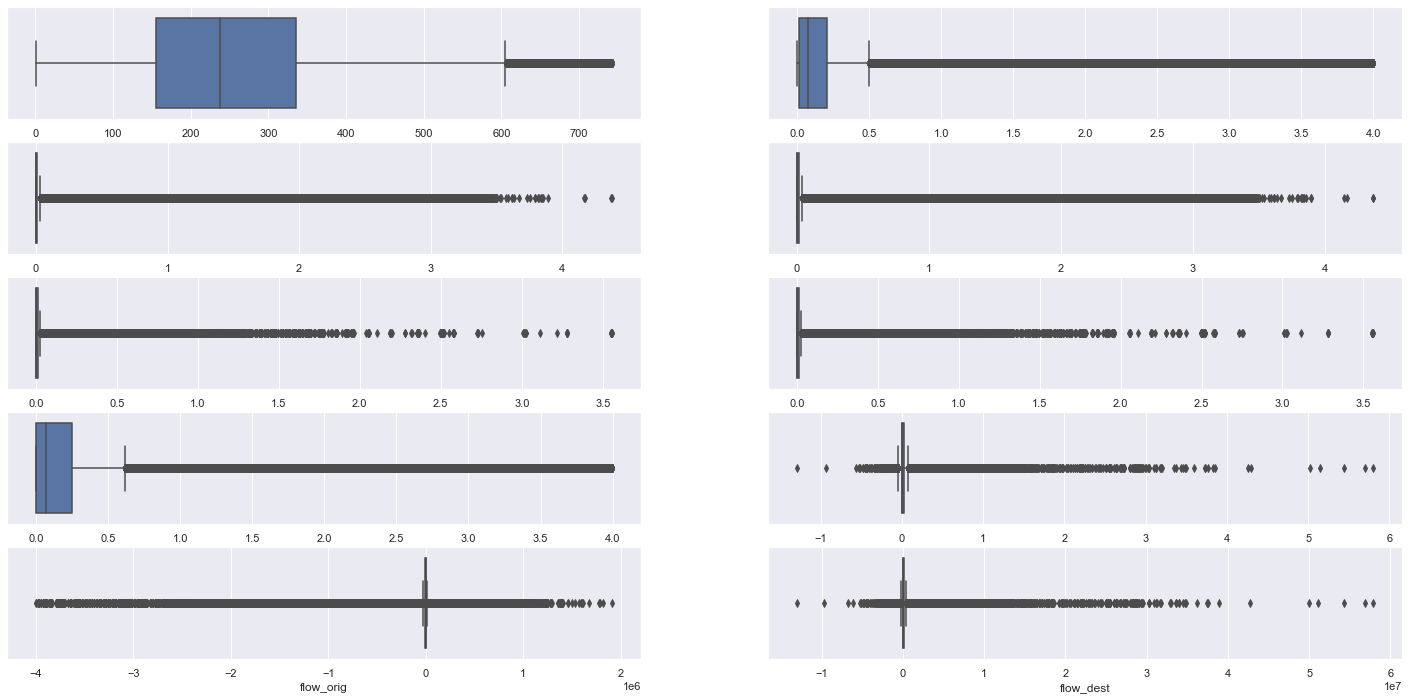

In [84]:
#plotting numerical variables
plt.subplot(5,2,1)
sns.boxplot(df5['step'])

plt.subplot(5,2,2)
sns.boxplot(df5['amount'])

plt.subplot(5,2,3)
sns.boxplot(df5['oldbalance_org'])

plt.subplot(5,2,4)
sns.boxplot(df5['newbalance_orig'])

plt.subplot(5,2,5)
sns.boxplot(df5['oldbalance_dest'])

plt.subplot(5,2,6)
sns.boxplot(df5['newbalance_dest'])

plt.subplot(5,2,7)
sns.boxplot(df5['error_balance_orig'])

plt.subplot(5,2,8)
sns.boxplot(df5['error_balance_dest'])

plt.subplot(5,2,9)
sns.boxplot(df5['flow_orig'])

plt.subplot(5,2,10)
sns.boxplot(df5['flow_dest'])

(array([2375045.,       0.,       0., 2795321.,       0.,       0.,
         931773.,       0.,       0.,  245460.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

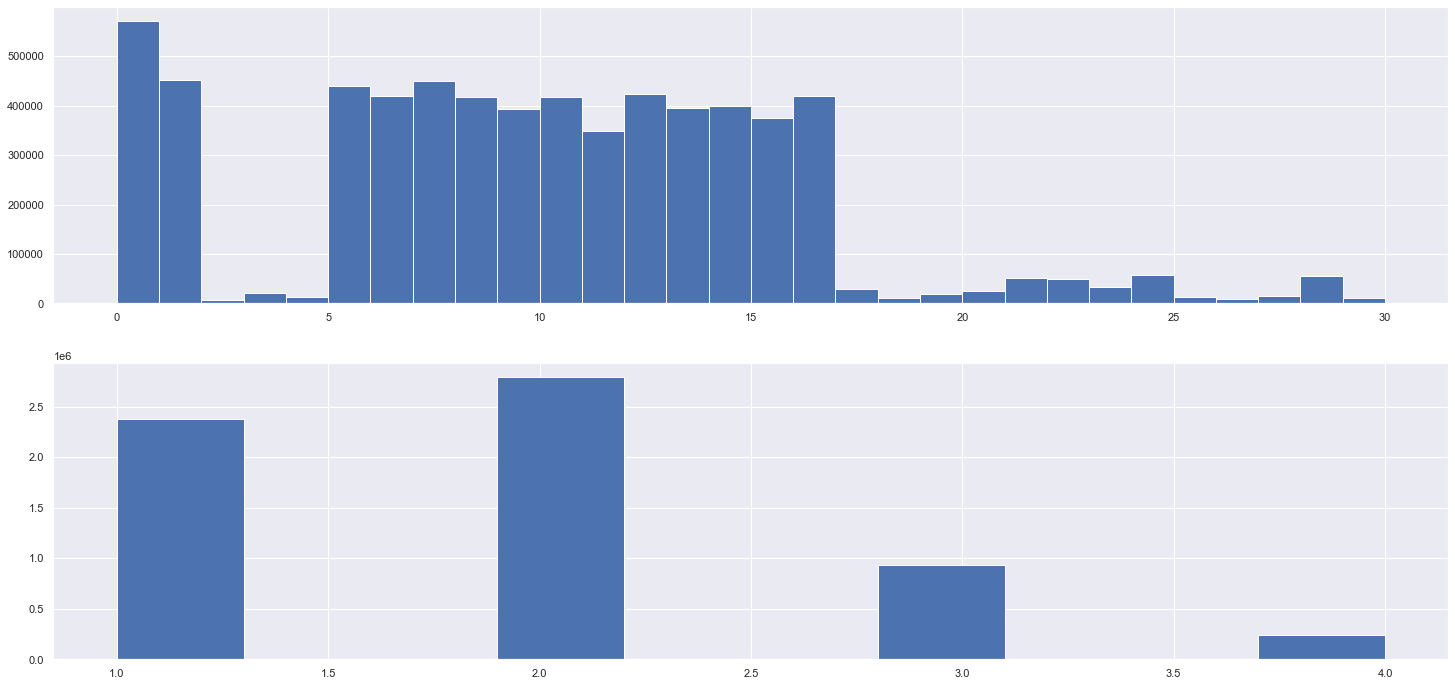

In [85]:
#plotting day and week
plt.subplot(2,1,1)
plt.hist(df5['day'], bins=30)

plt.subplot(2,1,2)
plt.hist(df5['week_of_month'])

## 5.2. Rescaling

- Robust Scaler:
 - amount
 - oldbalance_org
 - newbalance_org
 - oldbalance_dest
 - newbalance_dest 
 - error_balance_orig
 - error_balance_dest
 - flow_orig
 - flow_dest
<br></br>
- MinMaxScaler:
 - step
 - day

In [86]:
#define models
rs = RobustScaler()
mms = MinMaxScaler()

#RobustScaler
df5['amount'] = rs.fit_transform(df5[['amount']])

df5['oldbalance_org'] = rs.fit_transform(df5[['oldbalance_org']])

df5['newbalance_orig'] = rs.fit_transform(df5[['newbalance_orig']])

df5['oldbalance_dest'] = rs.fit_transform(df5[['oldbalance_dest']])

df5['newbalance_dest'] = rs.fit_transform(df5[['newbalance_dest']])

df5['error_balance_orig'] = rs.fit_transform(df5[['error_balance_orig']])

df5['error_balance_dest'] = rs.fit_transform(df5[['error_balance_dest']])

df5['flow_orig'] = rs.fit_transform(df5[['flow_orig']])

df5['flow_dest'] = rs.fit_transform(df5[['flow_dest']])


#MinMaxScaler
df5['step'] = mms.fit_transform(df5[['step']])

df5['day'] = mms.fit_transform(df5[['day']])

## 5.2. Encoding

In [88]:
#define categories
client = {'Costumer':'0','Merchant':1}
types = {"CASH_OUT":0,'PAYMENT':1,'CASH_IN':2, 'TRANSFER':3,'DEBIT':4}

#encoding
df5['client_dest'] = df5['client_dest'].map(client)
df5['client_orig'] = df5['client_orig'].map(client)
df5['type'] = df5['type'].map(types)

In [89]:
df5.head() 

,step,type,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,error_balance_orig,error_balance_dest,flow_orig,flow_dest,client_dest,client_orig,day,week_of_month,weekend
0,0.0,1,-0.332207,1.450246,1.104149,-0.140288,-0.193107,0,0,-0.277739,-0.058303,-0.970666,0.000000,1,0,0.0,1,0
1,0.0,1,-0.373278,0.064580,0.133525,-0.140288,-0.193107,0,0,-0.277739,-0.084733,-0.183908,0.000000,1,0,0.0,1,0
2,0.0,3,-0.381947,-0.131496,0.000000,-0.140288,-0.193107,1,0,-0.277739,-0.090311,-0.017855,0.000000,0,0,0.0,1,0
3,0.0,0,-0.381947,-0.131496,0.000000,-0.117672,-0.193107,1,0,-0.277739,-0.160505,-0.017855,-0.143492,0,0,0.0,1,0
4,0.0,1,-0.322791,0.253555,0.205859,-0.140288,-0.193107,0,0,-0.277739,-0.052244,-1.151045,0.000000,1,0,0.0,1,0


# 6.0. FEATURE SELECTION

- RFE (Recursive Feature Elimination)
- Random Forest
- Boruta

In [92]:
df6=df5.copy()

In [93]:
#split data
X = df6.drop(columns = 'is_fraud', axis = 1)
y = df6['is_fraud']

## 6.1. Recursive Feature Elimination (RFE)

In [344]:
#define model
rf = RandomForestClassifier(n_jobs = -1)

#feature selector
selector = RFE(rf, n_features_to_select = 7, step = 1)
selector = selector.fit(X,y)

#get ranking
selector.support_

array([ True, False,  True, False,  True, False,  True, False,  True,
        True,  True, False, False, False, False, False, False])

In [346]:
columns_selected = ['step','amount','oldbalance_org','newbalance_orig','error_balance_orig','error_balance_dest','client_dest']
columns_selected

['step',
 'amount',
 'oldbalance_org',
 'newbalance_orig',
 'error_balance_orig',
 'error_balance_dest',
 'client_dest']

## 6.2. RandomForest as a Feature Selector

<AxesSubplot:>

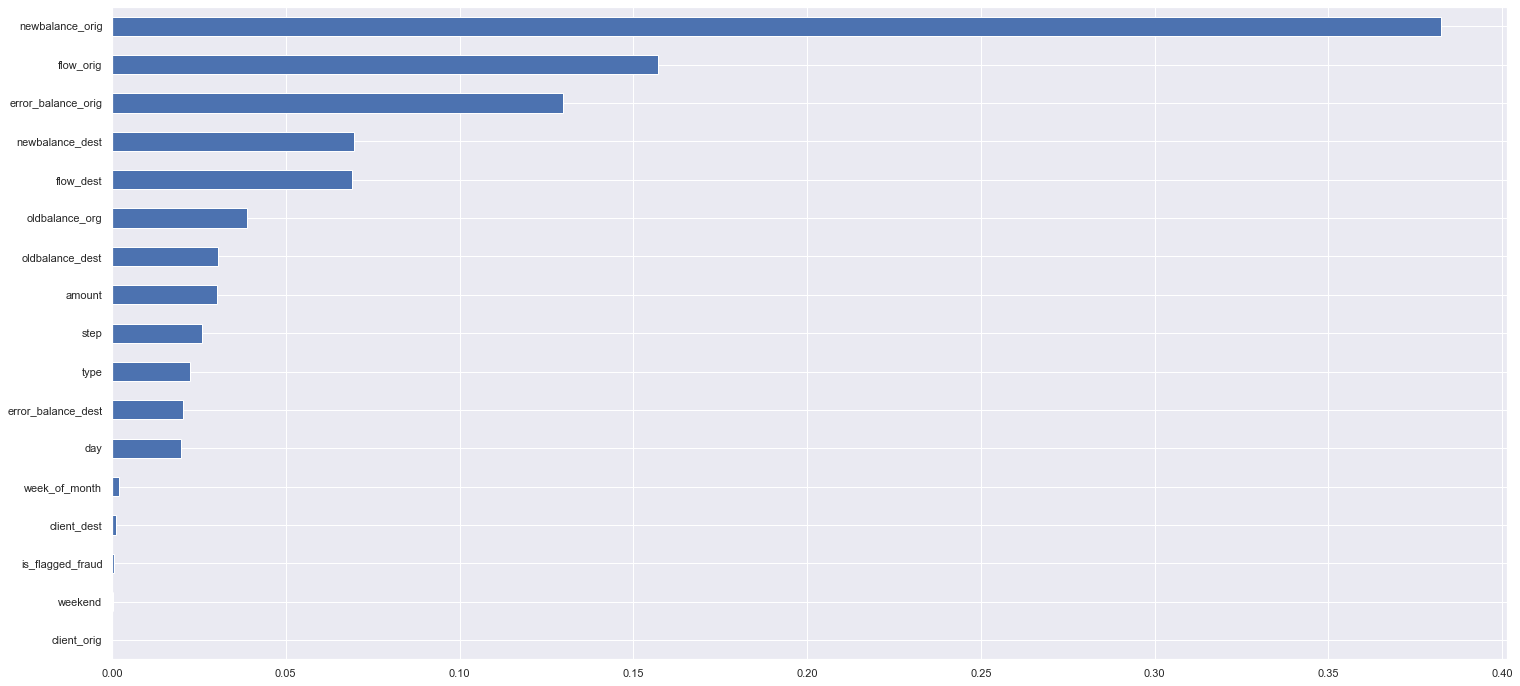

In [342]:
#feature importances 
rf_model = RandomForestClassifier(n_jobs = -1)
rf_model.fit(X, y)

feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh')

In [343]:
cols_selected_rf = ['flow_orig',
                    'flow_dest', 
                    'amount',
                    'oldbalance_org',
                    'oldbalance_dest',
                    'newbalance_orig',
                    'newbalance_dest',
                    'error_balance_orig',
                    'step',
                    'type']

## 6.3. Boruta as Feature Selector

In [340]:
#define model
xgb_model = xgb.XGBClassifier(n_jobs=-1)
#extra_model = ExtraTreesClassifier(n_jobs=-1)
#rf_model = RandomForestClassifier(n_jobs = -1)

#split data 
X_train_nn = X.values
y_train_nn = y.values.ravel()

#define boruta
boruta = BorutaPy(xgb_model, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_nn, y_train_nn)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	10
Tentative: 	4
Rejected: 	3
Iteration: 	9 / 100
Confirmed: 	10
Tentative: 	4
Rejected: 	3
Iteration: 	10 / 100
Confirmed: 	10
Tentative: 	4
Rejected: 	3
Iteration: 	11 / 100
Confirmed: 	10
Tentative: 	4
Rejected: 	3
Iteration: 	12 / 100
Confirmed: 	10
Tentative: 	3
Rejected: 	4
Iteration: 	13 / 100
Confirmed: 	10
Tentative: 	3
Rejected: 	4
Iteration: 	14 / 100
Confirmed: 	10
Tentative: 	3
Rejected: 	4
Iteration: 	15 / 100
Confirmed: 	10
Tentative: 	3
Rejected: 	4
Iteration: 	16 / 100
Confirmed: 	10
Tentative: 	3
Rejected: 	4
I

In [341]:
#best features from boruta
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['step',
 'type',
 'oldbalance_org',
 'newbalance_orig',
 'oldbalance_dest',
 'newbalance_dest',
 'is_flagged_fraud',
 'error_balance_orig',
 'flow_orig',
 'day']

## 6.4. Manual Feature Selection

In [94]:
##features that will be important to our model
cols_selected = ['type',
 'amount',
 'oldbalance_org',
 'newbalance_orig',
 'oldbalance_dest',
 'newbalance_dest',
 'error_balance_orig',
 'error_balance_dest',
 'flow_orig',
 'flow_dest',
 'day',
 'is_fraud']

#creating a dataframe with selected columns
df6 = df6[cols_selected]

# 7.0. BALANCED DATASET (SMOTE + TOMEKLINK)

Oversampling:
Synthetic Minority Over-sampling Technique

Over-sampling using SMOTE and cleaning using Tomek links.
Combine over- and under-sampling using SMOTE and Tomek links.

In [95]:
df7 = df6.copy()

In [96]:
#target variable and features split 
X = df7.drop(columns = 'is_fraud',axis = 1)
y = df7['is_fraud']

#train test split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [97]:
#concat datast
X_train['is_fraud'] = y_train

In [98]:
#Smote + Tomeklink
#define sampler
smt = c.SMOTETomek(sampling_strategy = 'auto', random_state = 32, n_jobs = -1)

#apply sampler
x_smt, y_smt = smt.fit_resample(X_train, X_train['is_fraud'])

In [99]:
y_smt.value_counts()

0    4438239
1    4438239
Name: is_fraud, dtype: int64

In [100]:
X_train = X_train.drop(columns = 'is_fraud', axis = 1)
y_train = y_smt

# 8.0. MACHINE LEARNING MODELLING
- Logistic Regression
- Stochastic Gradient Descent
- LGBM Classifier
- Random Forest Classifier

## 8.1. Logistic Regression

In [ ]:
#define model
logreg = LogisticRegression()

#training model
model = logreg.fit(X_train.values,y_train.values)

#predict model
yhat_log = model.predict(X_test)

#performance
result_log = pd.DataFrame(["Logistic Regression",accuracy_score(y_test,yhat_log),cohen_kappa_score(y_test,yhat_log),
                          recall_score(y_test,yhat_log), f1_score(y_test,yhat_log),
                           precision_score(y_test,yhat_log)]).T
result_log.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_log))

In [221]:
#print result summary
result_log

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Logistic Regression,0.96638,0.290763,0.88855,0.300335,0.180708


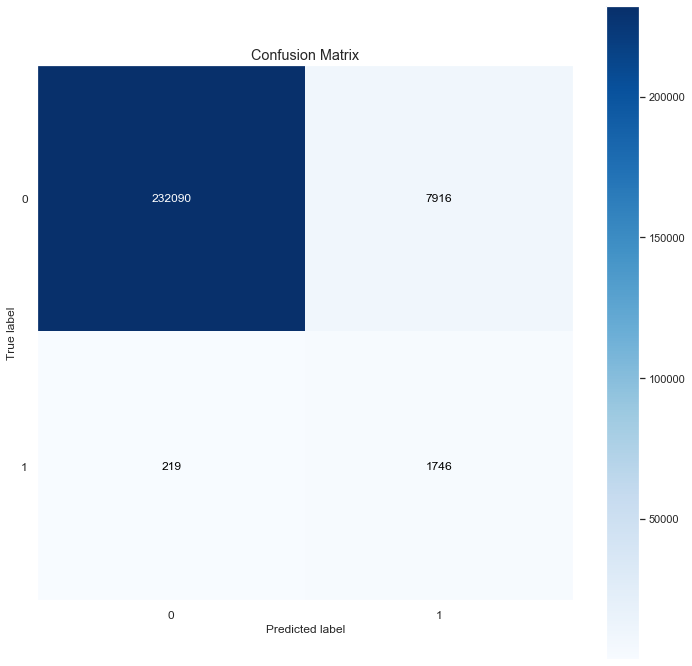

In [222]:
#confusion_matrix
mt.plot_confusion_matrix(y_test,yhat_log, normalize = False, figsize = (12,12))

## 8.2. Stochastic Gradient Descent

In [240]:
#model definition
sgb = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)

#fit model
sgb.fit(X_train,y_train)

#prediction
yhat_sgb = sgb.predict(X_test)

#performance
result_sgb = pd.DataFrame(["Stochastic Gradient Descent",accuracy_score(y_test,yhat_sgb),cohen_kappa_score(y_test,yhat_sgb),
                          recall_score(y_test,yhat_sgb), f1_score(y_test,yhat_sgb),
                          precision_score(y_test,yhat_sgb)]).T
result_sgb.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_sgb))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    240006
           1       0.15      0.91      0.26      1965

    accuracy                           0.96    241971
   macro avg       0.57      0.93      0.62    241971
weighted avg       0.99      0.96      0.97    241971



In [241]:
result_sgb

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Stochastic Gradient Descent,0.957239,0.245355,0.905344,0.255879,0.148995


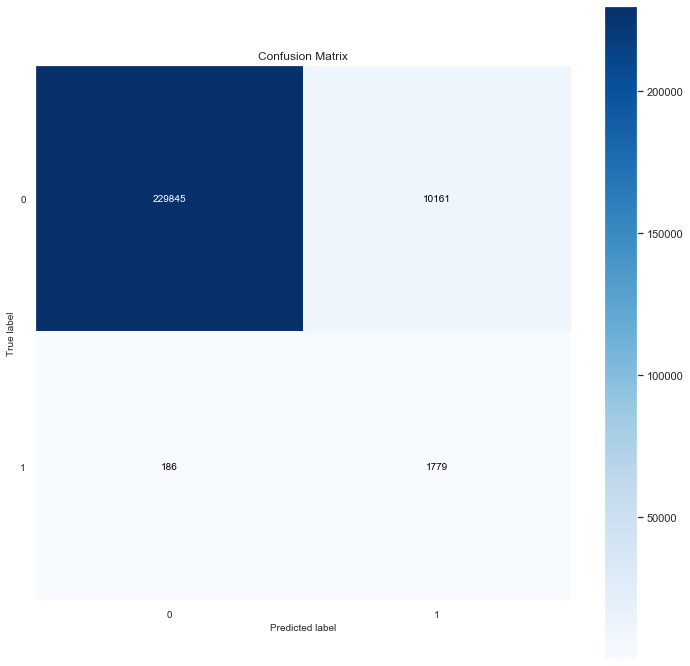

In [242]:
#confusion matrix
mt.plot_confusion_matrix(y_test, yhat_sgb, normalize = False, figsize = (12,12))

## 8.3. RandomForestClassifier

In [227]:
#define model
rf = RandomForestClassifier(n_jobs = -1)

#training model
rf.fit(X_train, y_train)

#predict model
yhat_rf = rf.predict(X_test)

#performance
result_rf = pd.DataFrame(["Random Forest Classifier",accuracy_score(y_test,yhat_rf),cohen_kappa_score(y_test,yhat_rf),
                          recall_score(y_test,yhat_rf), f1_score(y_test,yhat_rf),
                           precision_score(y_test,yhat_rf)]).T
result_rf.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    240006
           1       0.99      1.00      0.99      1965

    accuracy                           1.00    241971
   macro avg       0.99      1.00      1.00    241971
weighted avg       1.00      1.00      1.00    241971



In [228]:
result_rf

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Random Forest Classifier,0.999876,0.992343,0.997455,0.992405,0.987406


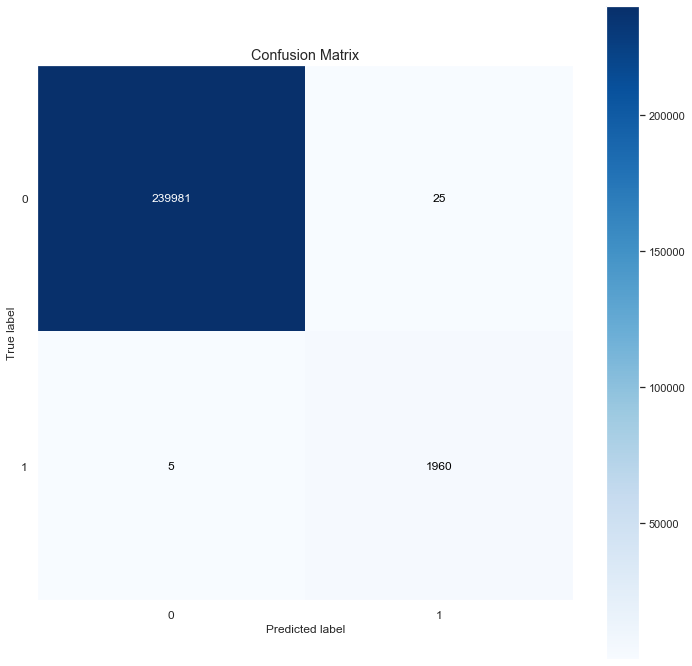

In [229]:
#confusion_matrix
mt.plot_confusion_matrix(y_test,yhat_rf, normalize = False, figsize = (12,12))

## 8.4. LGBMClassifier

In [223]:
#define model
lgbm = LGBMClassifier(n_jobs = -1)

#train_model
lgbm.fit(X_train.values, y_train.values)

#predict model
yhat_lgbm = lgbm.predict(X_test)

#performance
result_lgbm = pd.DataFrame(["LGBM Classifier",accuracy_score(y_test,yhat_lgbm),cohen_kappa_score(y_test,yhat_lgbm),
                          recall_score(y_test,yhat_lgbm), f1_score(y_test,yhat_lgbm),
                           precision_score(y_test,yhat_lgbm)]).T
result_lgbm.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_lgbm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    240006
           1       0.98      1.00      0.99      1965

    accuracy                           1.00    241971
   macro avg       0.99      1.00      0.99    241971
weighted avg       1.00      1.00      1.00    241971



In [224]:
result_lgbm

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,LGBM Classifier,0.999793,0.987301,0.997455,0.987406,0.977556


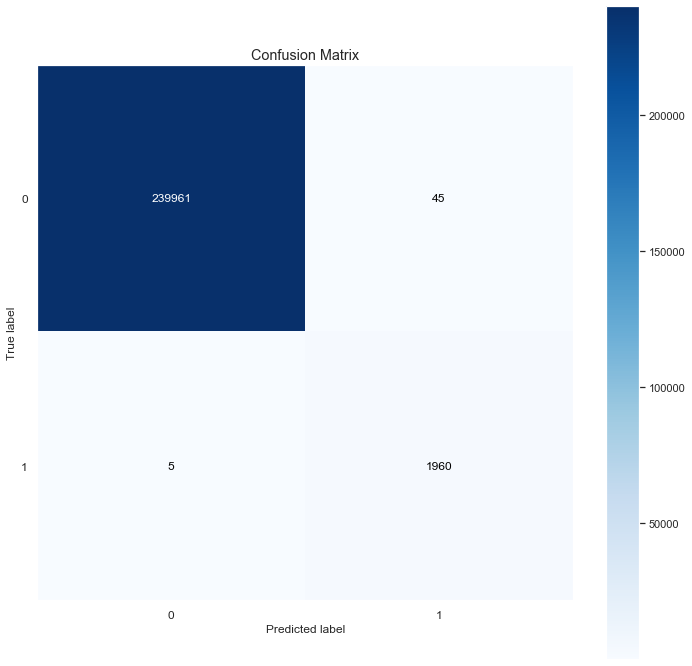

In [225]:
#confusion matrix
mt.plot_confusion_matrix(y_test, yhat_lgbm, normalize = False, figsize = (12,12))

## 8.5. Machine Learning Performance

In [244]:
#concat each performance as a dataframe
performance = pd.concat([result_log,result_rf,result_lgbm,result_sgb])
performance.sort_values('Precision_score', ascending = False)

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Random Forest Classifier,0.999876,0.992343,0.997455,0.992405,0.987406
0,LGBM Classifier,0.999793,0.987301,0.997455,0.987406,0.977556
0,Logistic Regression,0.96638,0.290763,0.88855,0.300335,0.180708
0,Stochastic Gradient Descent,0.957239,0.245355,0.905344,0.255879,0.148995


- Random Forest is the machine learning model with the best performance.

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.975
LGBM: ROC AUC=1.000
RandomForestClassifier: ROC AUC=0.999


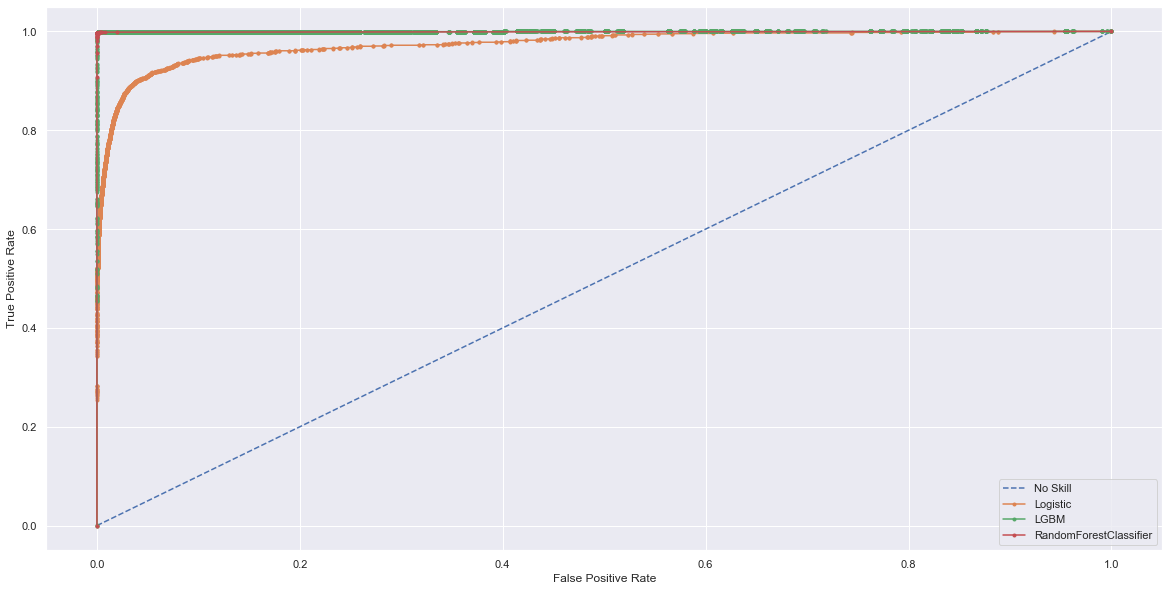

In [250]:
#machine leraning model
lr_probs = logreg.predict_proba(X_test)
lgbm_probs = lgbm.predict_proba(X_test)
#sgb_probs = sgb.predict_proba(X_test)
rf_probs = rf.predict_proba(X_test)


# keep probabilities for the positive outcome only
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = lr_probs[:, 1]
lgbm_probs = lgbm_probs[:,1]
#sgb_probs = knn_probs[:,1]
rf_probs = rf_probs[:,1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
lgbm_auc = roc_auc_score(y_test, lgbm_probs)
#sgb_auc = roc_auc_score(y_test, knn_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('LGBM: ROC AUC=%.3f' % (lgbm_auc))
#print('Stochastic Gradient Descent: ROC AUC=%.3f' % (sgb_auc))
print('RandomForestClassifier: ROC AUC=%.3f' % (rf_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, lgbm_probs)
#sgb_fpr, sgb_tpr, _ = roc_curve(y_test, sgb_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

#plot
plt.figure(figsize = (20,10))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.plot(lgbm_fpr, lgbm_tpr, marker='.', label='LGBM')
#plt.plot(sgb_fpr, sgb_tpr, marker='.', label='SGB')
plt.plot(rf_fpr, rf_tpr, marker='.', label='RandomForestClassifier')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## 8.6 RandomForestClassifier - Cross-Validation - Real Performance

In [246]:
#cross validation scores
rf_cv = cross_val_score(rf,X_train, y_train.ravel(), cv = 10, n_jobs = -1)

Average: 0.9998 +/- Std 0.0


In [247]:

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(rf_cv),4),np.round(np.std(rf_cv),6)))

Average: 0.9998 +/- Std 4.1e-05


# 9.0. HYPERPARAMETER FINE TUNNING

## 9.1. Random Search CV

In [251]:
#define model
rf_hyper = RandomForestClassifier(n_jobs = -1, random_state = 42)

#parameters
parameters =  {'max_depth': np.arange(2, 12, 2), 
         'n_estimators': np.arange(10, 105, 15)}

#define random search cv
rf_hyper_cv = RandomizedSearchCV(estimator=rf_hyper, param_distributions=parameters,
                                scoring='accuracy', n_iter=100, cv=10, verbose=2,
                                random_state=42, n_jobs=-1)

#fit RandomSearchCV
rf_hyper_cv.fit(X_train, np.ravel(y_train))

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 88.8min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed: 351.5min finished


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': array([ 2,  4,  6,  8, 10]),
                                        'n_estimators': array([ 10,  25,  40,  55,  70,  85, 100])},
                   random_state=42, scoring='accuracy', verbose=2)

In [253]:
#get the best parameters to our model
rf_hyper_cv.best_estimator_

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

## 9.2. Fit the model with the best parameters

In [254]:
#define model
rf_hyper = RandomForestClassifier(max_depth = 10, n_jobs = -1, random_state = 42)

#fit the model
rf_hyper.fit(X_train.values,y_train.values)

#predict model
yhat_rf_hyper = rf_hyper.predict(X_test)

#performance

#performance
result_rf_hyper = pd.DataFrame(["Random Forest Classifier",accuracy_score(y_test,yhat_rf_hyper),cohen_kappa_score(y_test,yhat_rf_hyper),
                          recall_score(y_test,yhat_rf_hyper), f1_score(y_test,yhat_rf_hyper),
                           precision_score(y_test,yhat_rf_hyper)]).T
result_rf_hyper.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_rf_hyper))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    240006
           1       1.00      1.00      1.00      1965

    accuracy                           1.00    241971
   macro avg       1.00      1.00      1.00    241971
weighted avg       1.00      1.00      1.00    241971



In [291]:
result_rf_hyper

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Random Forest Classifier,0.999963,0.997691,0.997455,0.997709,0.997963


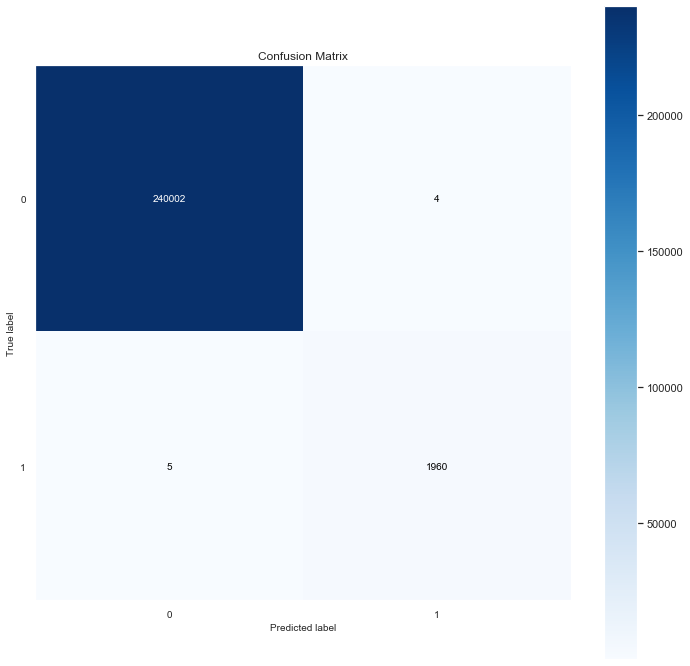

In [256]:
#confusion matrix
mt.plot_confusion_matrix(y_test, yhat_rf_hyper, normalize = False, figsize = (12,12))

#precision_recall_curve
plot_precision_recall_curve(rf_hyper, X_train, y_train);

In [271]:
#save model in picke
pickle.dump(rf_hyper,open('C:\ProjetosDataScience\ComunidadeDS\model\model.pkl','wb'))

## 9.3. Real Performance - Cross-Validation

In [260]:
#cross validation scores
rf_hyper_cv_final = cross_val_score(rf_hyper,X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(rf_hyper_cv_final),4),np.round(np.std(rf_hyper_cv_final),4)))

Average: 0.999 +/- Std 0.0001


# 10.0. BUSINESS PERFORMANCE

## 10.1 Finacial Return

In [337]:
X_test['is_fraud'] = y_test
X_test['predictions'] = yhat_rf_hyper
X_test['amount'] = rs.inverse_transform(X_test)

In [ ]:
#1 - transaction that are truly detected as fraud
fraudulent_transactions = X_test[(X_test['is_fraud'] == 1) & (X_test['predictions'] == 1)]
fraudulent_detected = fraudulent_transactions[['amount','is_fraud','predictions']].groupby(["is_fraud",'predictions']).sum().reset_index()
fraudulent_detected['gain'] = np.round(fraudulent_detected['amount']*0.25,4)

print("1 --- Using a sample of 241971 costumers, Blocker Fraud Company will Recieve ${:,.2f} for the transactions truly detected as fraud".format(fraudulent_detected['gain'][0]))

#2 -The company receives 5% of each transaction value if it was wrongly classified as fraud.
aux1 = X_test[(X_test['is_fraud'] == 0) & (X_test['predictions'] == 1)]
aux2 = aux1[['is_fraud','predictions','amount']].groupby(['is_fraud','predictions']).sum().reset_index()
aux2['gain'] = aux2['amount']*0.05

print("\n")
print("2 --- Using a sample of 241971 costumers, Blocker Fraud Comapany will receive ${:,.2f} for the transactions detected as fraud, which were actually legitimate.".format(aux2['gain'][0]))

#3 -The company gives back 100% of the value to the customer if the transaction is was wrongly classified as legitimate.
aux3 = X_test[(X_test['is_fraud'] == 1) & (X_test['predictions'] == 0)]
aux3 = aux3[['is_fraud','predictions','amount']].groupby(['is_fraud','predictions']).sum().reset_index()
aux3['gain'] = aux3['amount']*1

print("\n")
print("3 --- Using a sample of 241971 costumers, Blocker Fraud Company will receive ${:,.2f} due to transactions detected as legitimate, which were actually fraudulent".format(aux3['gain'][0]))

## 10.2. Model's Performance and Business

In [108]:
#print results
print("- What are the model's Precision and Accuracy?")
print("Precision:")
print(0.997963)
print("Accuracy:")
print(0.999963)
print("\n")
print("- How reliable is the model in classifying transactions as legitimate or fraudulent?")
print("The model can detect 99% of the fraudulent transactions. The false positive rate is 0.001%.")


- What are the model's Precision and Accuracy?
Precision:
0.997963
Accuracy:
0.999963


- How reliable is the model in classifying transactions as legitimate or fraudulent?
The model can detect 99% of the fraudulent transactions. The false positive rate is 0.001%.


# 11.0. DEPLOY MODEL TO PRODUCTION

## 11.1. Fraud Class

In [66]:
import pickle
import pandas as pd
import numpy as np
import inflection

class FraudDetection( object ):
    def __init__(self):
        
        #load scalers
        self.amount_scaler = pickle.load(open("/home/cecilia/cecilia/pa002_blocker_fraud_company/parameter/scaler_amount.pkl",'rb'))
        self.oldbalance_org_scaler = pickle.load(open("/home/cecilia/cecilia/pa002_blocker_fraud_company/parameter/scaler_oldbalance_org.pkl",'rb'))
        self.newbalance_orig_scaler = pickle.load(open("/home/cecilia/cecilia/pa002_blocker_fraud_company/parameter/scaler_newbalance_orig.pkl",'rb'))
        self.oldbalance_dest_scaler = pickle.load(open("/home/cecilia/cecilia/pa002_blocker_fraud_company/parameter/scaler_oldbalance_dest.pkl",'rb'))
        self.newbalance_dest_scaler = pickle.load(open("/home/cecilia/cecilia/pa002_blocker_fraud_company/parameter/scaler_newbalance_dest.pkl",'rb'))
        self.error_balance_orig_scaler = pickle.load(open("/home/cecilia/cecilia/pa002_blocker_fraud_company/parameter/scaler_error_balance_orig.pkl",'rb'))
        self.error_balance_dest_scaler = pickle.load(open("/home/cecilia/cecilia/pa002_blocker_fraud_company/parameter/scaler_error_balance_dest.pkl",'rb'))
        self.flow_orig_scaler = pickle.load(open("/home/cecilia/cecilia/pa002_blocker_fraud_company/parameter/scaler_flow_orig.pkl",'rb'))
        self.flow_dest_scaler = pickle.load(open("/home/cecilia/cecilia/pa002_blocker_fraud_company/parameter/scaler_flow_dest.pkl",'rb'))
        self.step_scaler = pickle.load(open("/home/cecilia/cecilia/pa002_blocker_fraud_company/parameter/scaler_step.pkl",'rb'))
        self.day_scaler = pickle.load(open("/home/cecilia/cecilia/pa002_blocker_fraud_company/parameter/scaler_day.pkl",'rb'))

    def data_cleaning(self, df1):
        
        ## 1.1. Rename Columns
        cols_old = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
               'nameDest', 'oldbalanceDest', 'newbalanceDest','isFlaggedFraud']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase,cols_old))
        cols_new

        #change columns names
        df1.columns = cols_new        
        return df1

    
    def feature_engineering(self, df2):
        
        ## 2.4. Feature Engineering

        #error balance 
        df2['error_balance_orig'] = np.round((df2['newbalance_orig'] + df2['amount'] - df2['oldbalance_org']),2)
        df2['error_balance_dest'] = df2['newbalance_dest'] + df2['amount'] - df2['oldbalance_dest']
        df2['flow_orig'] = df2['newbalance_orig'] - df2['oldbalance_org']
        df2['flow_dest'] = df2['newbalance_dest'] - df2['oldbalance_dest']

        #client
        df2['client_dest'] = df2['name_dest'].apply(lambda x: "Merchant" if "M" in x else "Costumer")
        df2['client_orig'] = df2['name_orig'].apply(lambda x: 'Merchant' if "M" in x else "Costumer")

        #step
        df2['day'] = df2['step'].apply(lambda x: int(x/24))

        #weekend
        df2['week_of_month'] = df2['day'].apply(lambda x: 1 if (x <=7) else 2 if (x <= 14) & (x>7) else 3 if (x > 14) & (x<=21) else 4)

        #weekend
        df2['weekend'] = df2['day'].apply(lambda x: 1 if (x == 7) or (x == 6) or (x == 14) or (x == 13) or (x == 20) or (x == 21) or (x == 27) or (x == 28) else 0)

        ##DATA FILTERING
        
        #removing features that will not necessary to us
        df2.drop(columns = ['name_orig','name_dest'], axis = 1, inplace = True)

        #amount
        df2 = df2[df2['amount'] < 2.108805e+06]

        #oldbalance_org
        df2 = df2[df2['oldbalance_dest'] < 9.384180e+06]
        
        return df2
    
    def data_preparation(self, df5):

        #RobustScaler
        df5['amount'] = self.amount_scaler.fit_transform(df5[['amount']])

        df5['oldbalance_org'] = self.oldbalance_org_scaler.fit_transform(df5[['oldbalance_org']])

        df5['newbalance_orig'] = self.newbalance_orig_scaler.fit_transform(df5[['newbalance_orig']])

        df5['oldbalance_dest'] = self.oldbalance_dest_scaler.fit_transform(df5[['oldbalance_dest']])

        df5['newbalance_dest'] = self.newbalance_dest_scaler.fit_transform(df5[['newbalance_dest']])

        df5['error_balance_orig'] = self.error_balance_orig_scaler.fit_transform(df5[['error_balance_orig']])

        df5['error_balance_dest'] = self.error_balance_dest_scaler.fit_transform(df5[['error_balance_dest']])

        df5['flow_orig'] = self.flow_orig_scaler.fit_transform(df5[['flow_orig']])

        df5['flow_dest'] = self.flow_dest_scaler.fit_transform(df5[['flow_dest']])


        #MinMaxScaler
        df5['step'] = self.step_scaler.fit_transform(df5[['step']])

        df5['day'] = self.day_scaler.fit_transform(df5[['day']])

        ##ENCODING
        client = {'Costumer':'0','Merchant':1}
        types = {"CASH_OUT":0,'PAYMENT':1,'CASH_IN':2, 'TRANSFER':3,'DEBIT':4}

        #encoding
        df5['client_dest'] = df5['client_dest'].map(client)
        df5['client_orig'] = df5['client_orig'].map(client)
        df5['type'] = df5['type'].map(types)

        ##features that will be really important to our model
        cols_selected = ['type','amount','oldbalance_org','newbalance_orig','oldbalance_dest','newbalance_dest','error_balance_orig','error_balance_dest','flow_orig','flow_dest','day']

        #creating a dataframe with selected columns
        df5 = df5[cols_selected]
        
        return df5
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = pred
        
        return original_data.to_json( orient='records')

## 11.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response

from frauddetection.FraudDetection import FraudDetection

#loading model
model = pickle.load(open("/home/cecilia/cecilia/pa002_blocker_fraud_company/model/model.pkl",'rb'))

app = Flask(__name__)
@app.route("/frauddetection/predict", methods =['POST'])
def fraud_detection():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = FraudDetection()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, df2, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

## 11.3. API Tester

In [2]:
import requests

In [25]:
#drop is_fraud column
df_test = df_raw.sample(10000).drop(columns = 'isFraud', axis = 1)

#convert dataframe to json
data = json.dumps(df_test.to_dict(orient = 'records'))

In [26]:
#API Call
#url = 'http://0.0.0.0:5000/frauddetection/predict' #localhost
url = 'https://fraud-detection-test.herokuapp.com/frauddetection/predict' #api web
header = {'Content-type': 'application/json'} 
data = data

r = requests.post(url, data, headers = header)
print("Status Code {}".format(r.status_code))

Status Code 200


In [27]:
r.json()

[{'step': 94,
  'type': 'CASH_OUT',
  'amount': 248196.76,
  'oldbalance_org': 0.0,
  'newbalance_orig': 0.0,
  'oldbalance_dest': 413349.1,
  'newbalance_dest': 661545.86,
  'is_flagged_fraud': 0,
  'error_balance_orig': 248196.76,
  'error_balance_dest': 496393.52,
  'flow_orig': 0.0,
  'flow_dest': 248196.76,
  'client_dest': 'Costumer',
  'client_orig': 'Costumer',
  'day': 3,
  'week_of_month': 1,
  'weekend': 0,
  'prediction': 0},
 {'step': 355,
  'type': 'PAYMENT',
  'amount': 1329.53,
  'oldbalance_org': 76102.48,
  'newbalance_orig': 74772.94,
  'oldbalance_dest': 0.0,
  'newbalance_dest': 0.0,
  'is_flagged_fraud': 0,
  'error_balance_orig': -0.01,
  'error_balance_dest': 1329.53,
  'flow_orig': -1329.54,
  'flow_dest': 0.0,
  'client_dest': 'Merchant',
  'client_orig': 'Costumer',
  'day': 14,
  'week_of_month': 2,
  'weekend': 1,
  'prediction': 0},
 {'step': 45,
  'type': 'PAYMENT',
  'amount': 1681.96,
  'oldbalance_org': 313363.0,
  'newbalance_orig': 311681.04,
  'oldb

In [28]:
df = pd.DataFrame(r.json(), columns = r.json()[0].keys()) 

In [31]:
df.head()

,step,type,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_flagged_fraud,error_balance_orig,error_balance_dest,flow_orig,flow_dest,client_dest,client_orig,day,week_of_month,weekend,prediction
0,94,CASH_OUT,248196.76,0.00,0.00,413349.10,661545.86,0,248196.76,496393.52,0.00,248196.76,Costumer,Costumer,3,1,0,0
1,355,PAYMENT,1329.53,76102.48,74772.94,0.00,0.00,0,-0.01,1329.53,-1329.54,0.00,Merchant,Costumer,14,2,1,0
2,45,PAYMENT,1681.96,313363.00,311681.04,0.00,0.00,0,0.00,1681.96,-1681.96,0.00,Merchant,Costumer,1,1,0,0
3,353,CASH_OUT,157681.35,211730.00,54048.65,5883101.92,6040783.27,0,0.00,315362.70,-157681.35,157681.35,Costumer,Costumer,14,2,1,0
4,35,CASH_OUT,167499.13,0.00,0.00,497420.43,664919.56,0,167499.13,334998.26,0.00,167499.13,Costumer,Costumer,1,1,0,0


In [30]:
df.to_csv("data/df.csv")

In [33]:
df['amount'].mean()

145047.58282164496